## 1. Environment Setup

In [1]:
import sys
import warnings
import os

# Fix for potential OpenMP runtime conflicts
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from IPython.display import display, Markdown

from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity

warnings.filterwarnings('ignore')

# Ensure output directories exist
Path('plots').mkdir(exist_ok=True)
Path('tables').mkdir(exist_ok=True)

# Plot settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

RANDOM_SEED = 67
np.random.seed(RANDOM_SEED)

POPULATION = 'leader'

print("✓ Libraries loaded")
print(f"✓ Random seed: {RANDOM_SEED}")
print(f"✓ Population: {POPULATION.upper()}")

✓ Libraries loaded
✓ Random seed: 67
✓ Population: LEADER


## 2. Load Data and Metadata

In [2]:
# Load development sample for EFA
df_dev = pd.read_csv('data/AIRS_dev.csv')

# Load item metadata from Phase 0
with open('../data/airs_28item_complete.json', 'r', encoding='utf-8') as f:
    item_metadata = json.load(f)

# Extract structure
predictor_items = item_metadata['predictor_items']  # 24 items for EFA
outcome_items = item_metadata['outcome_items']  # 4 BI items (not in EFA)
constructs = item_metadata['constructs']
metadata = item_metadata['metadata']
positive_items = item_metadata['positive_items']
negative_items = item_metadata['negative_items']

print(f"Development sample: N = {len(df_dev)}")
print(f"Predictor items for EFA: {len(predictor_items)}")
print(f"Outcome items (BI): {len(outcome_items)}")
print(f"\nConstructs: {list(constructs.keys())}")

Development sample: N = 91
Predictor items for EFA: 24
Outcome items (BI): 4

Constructs: ['PE', 'EE', 'SI', 'FC', 'HM', 'PV', 'HB', 'VO', 'TR', 'EX', 'ER', 'AX', 'BI']


In [3]:
# Create analysis dataframe with predictor items only
df_efa = df_dev[predictor_items].copy()

# Check for missing values
missing = df_efa.isnull().sum()
if missing.sum() > 0:
    print(f"⚠️ Missing values detected:")
    print(missing[missing > 0])
else:
    print("✓ No missing values in predictor items")

print(f"\nEFA matrix shape: {df_efa.shape}")

✓ No missing values in predictor items

EFA matrix shape: (91, 24)


## 3. Descriptive Statistics

In [4]:
# Item descriptives
desc_stats = df_efa.describe().T
desc_stats['skewness'] = df_efa.skew()
desc_stats['kurtosis'] = df_efa.kurtosis()

# Add construct labels
desc_stats['construct'] = [metadata[item]['construct_abbr'] for item in desc_stats.index]
desc_stats['direction'] = [metadata[item]['direction'] for item in desc_stats.index]

# Reorder columns
desc_stats = desc_stats[['construct', 'direction', 'count', 'mean', 'std', 'min', 'max', 'skewness', 'kurtosis']]

print("Item Descriptive Statistics:")
display(desc_stats.round(3))

Item Descriptive Statistics:


,construct,direction,count,mean,std,min,max,skewness,kurtosis
PE1,PE,POSITIVE,91.0,3.934,1.114,1.0,5.0,-1.200,1.058
PE2,PE,POSITIVE,91.0,3.835,1.036,1.0,5.0,-1.073,0.883
EE1,EE,POSITIVE,91.0,3.967,0.994,1.0,5.0,-0.766,-0.088
EE2,EE,POSITIVE,91.0,3.846,0.999,1.0,5.0,-0.982,0.784
SI1,SI,POSITIVE,91.0,3.747,1.081,1.0,5.0,-0.933,0.457
SI2,SI,POSITIVE,91.0,3.934,1.020,1.0,5.0,-1.087,0.903
FC1,FC,POSITIVE,91.0,3.879,1.020,1.0,5.0,-0.780,-0.169
FC2,FC,POSITIVE,91.0,3.791,0.949,1.0,5.0,-1.003,1.126
HM1,HM,POSITIVE,91.0,3.989,1.059,1.0,5.0,-1.182,1.081
HM2,HM,POSITIVE,91.0,3.901,1.044,1.0,5.0,-1.056,0.649


In [5]:
# Check for normality issues (|skew| > 2 or |kurtosis| > 7)
skew_issues = desc_stats[abs(desc_stats['skewness']) > 2]
kurt_issues = desc_stats[abs(desc_stats['kurtosis']) > 7]

if len(skew_issues) > 0:
    print("⚠️ Items with |skewness| > 2:")
    print(skew_issues[['construct', 'skewness']])
else:
    print("✓ No severe skewness issues")

if len(kurt_issues) > 0:
    print("\n⚠️ Items with |kurtosis| > 7:")
    print(kurt_issues[['construct', 'kurtosis']])
else:
    print("✓ No severe kurtosis issues")

# Recommendation for estimator
if len(skew_issues) == 0 and len(kurt_issues) == 0:
    print("\n→ Recommendation: ML estimation appropriate")
else:
    print("\n→ Recommendation: Consider MINRES (more robust to non-normality)")

✓ No severe skewness issues
✓ No severe kurtosis issues

→ Recommendation: ML estimation appropriate


## 4. Within-Construct Item Analysis

Before conducting EFA on all items together, we must verify that items within each theoretical construct actually cohere. This validates that our 2-item scales measure their intended constructs.

**Key metrics:**
- **Inter-item correlation**: Should be moderate (.30-.70); too low = items don't belong together; too high = redundancy
- **Corrected item-total correlation**: ≥ .30 indicates item contributes to construct
- **Cronbach's α**: ≥ .70 acceptable for 2-item scales (Nunnally & Bernstein, 1994)
- **α if item deleted**: Dropping item should decrease α (not increase it)

In [6]:
# ============================================================================
# MANUAL ITEM SELECTION - THEORETICAL/SEMANTIC RELEVANCE FOR LEADER POPULATION
# ============================================================================
# Edit SELECTED_ITEMS to keep only items theoretically relevant for organizational leaders
# Each construct has 2 items - you can keep 1 or both based on semantic fit
# 
# ITEM REFERENCE FOR LEADER POPULATION:
# -------------------------------------------------------------------------------
# Performance Expectancy (PE):
#   PE1: "AI tools help me accomplish tasks more quickly."
#   PE2: "Using AI improves the quality of my work or studies."
#
# Effort Expectancy (EE):
#   EE1: "Learning to use AI tools is easy for me."
#   EE2: "Interacting with AI tools is clear and understandable."
#
# Social Influence (SI):
#   SI1: "People whose opinions I value encourage me to use AI tools."
#   SI2: "Leaders in my organization or school support the use of AI tools."
#
# Facilitating Conditions (FC):
#   FC1: "I have access to training or tutorials for the AI tools I use."
#   FC2: "The AI tools I use are compatible with other tools or systems I use."
#
# Hedonic Motivation (HM):
#   HM1: "Using AI tools is stimulating and engaging."
#   HM2: "AI tools make my work or studies more interesting."
#
# Price Value (PV):
#   PV1: "I get more value from AI tools than the effort they require."
#   PV2: "Using AI tools is worth the learning curve."
#
# Habit (HB):
#   HB1: "Using AI tools has become a habit for me."
#   HB2: "I tend to rely on AI tools by default when I need help with tasks."
#
# Voluntariness (VO):
#   VO1: "I choose to use AI tools in my work because I find them helpful, not because I am required to."
#   VO2: "I could choose not to use AI tools in my work or studies if I preferred."
#
# Trust in AI (TR):
#   TR1: "I trust AI tools to provide reliable information."
#   TR2: "I trust the AI tools that are available to me."
#
# Explainability (EX):
#   EX1: "I understand how the AI tools I use generate their outputs."
#   EX2: "I prefer AI tools that explain their recommendations."
#
# Perceived Ethical Risk (ER) - NEGATIVE direction:
#   ER1: "I worry that AI tools could replace jobs in my field."
#   ER2: "I am concerned about privacy risks when using AI tools."
#
# AI Anxiety (AX) - MIXED direction:
#   AX1: "I feel uneasy about the increasing use of AI." (NEGATIVE - barrier)
#   AX2: "I worry that I may be left behind if I do not keep up with AI." (POSITIVE - FOMO)
# -------------------------------------------------------------------------------

# EDIT THIS DICTIONARY: Remove items that are NOT theoretically relevant for leaders
# Default: All items selected. Remove item codes to exclude them.
SELECTED_ITEMS = {
    'PE': ['PE1'],  # Performance Expectancy
    'EE': ['EE1'],  # Effort Expectancy
    'SI': ['SI1', 'SI2'],  # Social Influence
    'FC': ['FC1', 'FC2'],  # Facilitating Conditions
    'HM': ['HM1'],  # Hedonic Motivation
    'PV': ['PV2'],  # Price Value
    'HB': ['HB1'],  # Habit
    'VO': ['VO1'],  # Voluntariness
    'TR': ['TR1'],  # Trust in AI
    'EX': ['EX2'],  # Explainability
    'ER': ['ER1', 'ER2'],  # Perceived Ethical Risk
    'AX': ['AX1', 'AX2'],  # AI Anxiety
}

# Apply selection - update working variables
selected_predictor_items = [item for items in SELECTED_ITEMS.values() for item in items]
selected_predictor_constructs = {k: v for k, v in SELECTED_ITEMS.items() if v}  # Only non-empty

# Validate selection
total_selected = len(selected_predictor_items)
constructs_with_selection = len([k for k, v in SELECTED_ITEMS.items() if v])
constructs_with_both = len([k for k, v in SELECTED_ITEMS.items() if len(v) == 2])
constructs_with_one = len([k for k, v in SELECTED_ITEMS.items() if len(v) == 1])
constructs_dropped = len([k for k, v in SELECTED_ITEMS.items() if len(v) == 0])

print("=" * 70)
print("MANUAL ITEM SELECTION - LEADER POPULATION")
print("=" * 70)
print(f"\nTotal items selected: {total_selected}/24")
print(f"Constructs with items: {constructs_with_selection}/12")
print(f"  - Both items retained: {constructs_with_both}")
print(f"  - One item retained: {constructs_with_one}")
print(f"  - Construct dropped: {constructs_dropped}")

print("\n" + "-" * 70)
print("SELECTED ITEMS BY CONSTRUCT:")
print("-" * 70)
for construct, items in SELECTED_ITEMS.items():
    construct_name = metadata.get(items[0], {}).get('construct', construct) if items else construct
    if items:
        print(f"\n{construct} ({construct_name}):")
        for item in items:
            item_text = metadata.get(item, {}).get('question_text', 'N/A')
            direction = metadata.get(item, {}).get('direction', 'N/A')
            print(f"  ✓ {item}: \"{item_text}\" [{direction}]")
    else:
        print(f"\n{construct}: [CONSTRUCT DROPPED - No items selected]")

# Update global variables for downstream analysis
predictor_items = selected_predictor_items
predictor_constructs = selected_predictor_constructs
df_efa = df_dev[predictor_items].copy()

print("\n" + "=" * 70)
print("Variables updated for downstream analysis:")
print(f"  - predictor_items: {len(predictor_items)} items")
print(f"  - predictor_constructs: {len(predictor_constructs)} constructs")
print(f"  - df_efa: {df_efa.shape[0]} observations × {df_efa.shape[1]} items")
print("=" * 70)

MANUAL ITEM SELECTION - LEADER POPULATION

Total items selected: 16/24
Constructs with items: 12/12
  - Both items retained: 4
  - One item retained: 8
  - Construct dropped: 0

----------------------------------------------------------------------
SELECTED ITEMS BY CONSTRUCT:
----------------------------------------------------------------------

PE (Performance Expectancy):
  ✓ PE1: "AI tools help me accomplish tasks more quickly." [POSITIVE]

EE (Effort Expectancy):
  ✓ EE1: "Learning to use AI tools is easy for me." [POSITIVE]

SI (Social Influence):
  ✓ SI1: "People whose opinions I value encourage me to use AI tools." [POSITIVE]
  ✓ SI2: "Leaders in my organization or school support the use of AI tools." [POSITIVE]

FC (Facilitating Conditions):
  ✓ FC1: "I have access to training or tutorials for the AI tools I use." [POSITIVE]
  ✓ FC2: "The AI tools I use are compatible with other tools or systems I use." [POSITIVE]

HM (Hedonic Motivation):
  ✓ HM1: "Using AI tools is stimulat

In [7]:
# ═══════════════════════════════════════════════════════════════════════════════
# WITHIN-CONSTRUCT ITEM ANALYSIS
# ═══════════════════════════════════════════════════════════════════════════════

def analyze_construct(df, items, construct_name):
    """
    Analyze items within a single construct.
    Returns dict with inter-item correlation, alpha, and item diagnostics.
    """
    if len(items) < 2:
        return {'construct': construct_name, 'n_items': len(items), 'error': 'Need at least 2 items'}
    
    construct_df = df[items]
    
    # Inter-item correlation matrix
    corr_matrix = construct_df.corr()
    
    # For 2-item scales: single inter-item correlation
    if len(items) == 2:
        inter_item_r = corr_matrix.iloc[0, 1]
    else:
        # Average off-diagonal correlations
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
        inter_item_r = corr_matrix.where(mask).stack().mean()
    
    # Cronbach's alpha
    n_items = len(items)
    item_vars = construct_df.var(axis=0, ddof=1)
    total_var = construct_df.sum(axis=1).var(ddof=1)
    alpha = (n_items / (n_items - 1)) * (1 - item_vars.sum() / total_var)
    
    # Item-total correlations (corrected)
    total_score = construct_df.sum(axis=1)
    item_total_corrs = {}
    alpha_if_deleted = {}
    
    for item in items:
        # Corrected item-total: correlate item with sum of OTHER items
        other_items = [i for i in items if i != item]
        if len(other_items) > 0:
            other_total = construct_df[other_items].sum(axis=1)
            item_total_corrs[item] = construct_df[item].corr(other_total)
        else:
            item_total_corrs[item] = np.nan
        
        # Alpha if item deleted
        if len(other_items) >= 2:
            other_df = construct_df[other_items]
            other_vars = other_df.var(axis=0, ddof=1)
            other_total_var = other_df.sum(axis=1).var(ddof=1)
            n_other = len(other_items)
            alpha_if_deleted[item] = (n_other / (n_other - 1)) * (1 - other_vars.sum() / other_total_var)
        else:
            alpha_if_deleted[item] = np.nan
    
    return {
        'construct': construct_name,
        'n_items': n_items,
        'items': items,
        'inter_item_r': inter_item_r,
        'alpha': alpha,
        'item_total_corrs': item_total_corrs,
        'alpha_if_deleted': alpha_if_deleted,
        'corr_matrix': corr_matrix
    }

# Analyze each predictor construct (excluding BI outcome)
construct_results = []
predictor_constructs = {k: v for k, v in constructs.items() if k != 'BI'}

print("="*70)
print("WITHIN-CONSTRUCT ITEM ANALYSIS")
print("="*70)
print("Validating that items within each theoretical construct cohere")
print("="*70)

for construct_name, items in predictor_constructs.items():
    # Filter to only items that exist in df_efa
    available_items = [item for item in items if item in df_efa.columns]
    if len(available_items) > 0:
        result = analyze_construct(df_efa, available_items, construct_name)
        construct_results.append(result)
    else:
        construct_results.append({'construct': construct_name, 'n_items': 0, 'error': 'No items selected'})

# Create summary table
summary_data = []
for r in construct_results:
    if 'error' not in r:
        summary_data.append({
            'Construct': r['construct'],
            'Items': ', '.join(r['items']),
            'N': r['n_items'],
            'Inter-Item r': r['inter_item_r'],
            'Cronbach α': r['alpha'],
            'Status': '✓' if r['alpha'] >= 0.70 and r['inter_item_r'] >= 0.30 else '⚠️'
        })

summary_df = pd.DataFrame(summary_data)
print("\nConstruct-Level Summary:")
display(summary_df.round(3))

WITHIN-CONSTRUCT ITEM ANALYSIS
Validating that items within each theoretical construct cohere

Construct-Level Summary:


,Construct,Items,N,Inter-Item r,Cronbach α,Status
0,SI,"SI1, SI2",2,0.761,0.863,✓
1,FC,"FC1, FC2",2,0.536,0.697,⚠️
2,ER,"ER1, ER2",2,0.388,0.546,⚠️
3,AX,"AX1, AX2",2,0.286,0.445,⚠️


In [8]:
# ═══════════════════════════════════════════════════════════════════════════════
# DETAILED ITEM-LEVEL DIAGNOSTICS
# ═══════════════════════════════════════════════════════════════════════════════

print("\nItem-Level Diagnostics by Construct:")
print("-"*70)

item_diagnostics = []

for r in construct_results:
    if 'error' in r:
        continue
    
    construct = r['construct']
    print(f"\n{construct} (α = {r['alpha']:.3f}, inter-item r = {r['inter_item_r']:.3f})")
    
    for item in r['items']:
        itc = r['item_total_corrs'].get(item, np.nan)
        aid = r['alpha_if_deleted'].get(item, np.nan)
        
        # Get item direction from metadata
        direction = metadata[item]['direction']
        
        # Flag issues
        issues = []
        if itc < 0.30:
            issues.append(f"Low ITC ({itc:.2f})")
        if not np.isnan(aid) and aid > r['alpha']:
            issues.append(f"α increases if deleted")
        
        status = '✓' if len(issues) == 0 else '⚠️ ' + '; '.join(issues)
        
        itc_str = f"{itc:.3f}" if not np.isnan(itc) else "N/A"
        aid_str = f"{aid:.3f}" if not np.isnan(aid) else "N/A"
        print(f"  {item}: ITC={itc_str:>6}, α-if-deleted={aid_str:>6}, Direction={direction:>8} {status}")
        
        item_diagnostics.append({
            'Construct': construct,
            'Item': item,
            'Direction': direction,
            'Item_Total_Corr': itc,
            'Alpha_If_Deleted': aid,
            'Construct_Alpha': r['alpha'],
            'Status': status
        })

# Create diagnostics dataframe
diagnostics_df = pd.DataFrame(item_diagnostics)


Item-Level Diagnostics by Construct:
----------------------------------------------------------------------

SI (α = 0.863, inter-item r = 0.761)
  SI1: ITC= 0.761, α-if-deleted=   N/A, Direction=POSITIVE ✓
  SI2: ITC= 0.761, α-if-deleted=   N/A, Direction=POSITIVE ✓

FC (α = 0.697, inter-item r = 0.536)
  FC1: ITC= 0.536, α-if-deleted=   N/A, Direction=POSITIVE ✓
  FC2: ITC= 0.536, α-if-deleted=   N/A, Direction=POSITIVE ✓

ER (α = 0.546, inter-item r = 0.388)
  ER1: ITC= 0.388, α-if-deleted=   N/A, Direction=NEGATIVE ✓
  ER2: ITC= 0.388, α-if-deleted=   N/A, Direction=NEGATIVE ✓

AX (α = 0.445, inter-item r = 0.286)
  AX1: ITC= 0.286, α-if-deleted=   N/A, Direction=NEGATIVE ⚠️ Low ITC (0.29)
  AX2: ITC= 0.286, α-if-deleted=   N/A, Direction=POSITIVE ⚠️ Low ITC (0.29)


In [9]:
# ═══════════════════════════════════════════════════════════════════════════════
# PROBLEMATIC CONSTRUCTS AND ITEMS SUMMARY
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("CONSTRUCT VALIDITY SUMMARY")
print("="*70)

# Flag problematic constructs
weak_constructs = summary_df[summary_df['Status'] == '⚠️']
strong_constructs = summary_df[summary_df['Status'] == '✓']

print(f"\n✓ Strong constructs (α ≥ .70 AND inter-item r ≥ .30): {len(strong_constructs)}/12")
if len(strong_constructs) > 0:
    for _, row in strong_constructs.iterrows():
        print(f"   {row['Construct']}: α = {row['Cronbach α']:.3f}, r = {row['Inter-Item r']:.3f}")

print(f"\n⚠️ Weak constructs: {len(weak_constructs)}/12")
if len(weak_constructs) > 0:
    for _, row in weak_constructs.iterrows():
        issues = []
        if row['Cronbach α'] < 0.70:
            issues.append(f"Low α ({row['Cronbach α']:.3f})")
        if row['Inter-Item r'] < 0.30:
            issues.append(f"Low inter-item r ({row['Inter-Item r']:.3f})")
        print(f"   {row['Construct']}: {'; '.join(issues)}")

# Flag problematic items
problem_items_construct = diagnostics_df[diagnostics_df['Status'].str.contains('⚠️')]
print(f"\n⚠️ Problematic items within constructs: {len(problem_items_construct)}/24")
if len(problem_items_construct) > 0:
    display(problem_items_construct[['Construct', 'Item', 'Direction', 'Item_Total_Corr', 'Alpha_If_Deleted', 'Status']].round(3))

# Special note on negative items
print("\n" + "-"*70)
print("NOTE ON NEGATIVE ITEMS (ER1, ER2, AX1):")
print("-"*70)
print("These items measure barriers/concerns and are scored in NEGATIVE direction.")
print("Low inter-item correlations with positive items are EXPECTED.")
print("Within their own construct (ER or AX), they should correlate positively.")


CONSTRUCT VALIDITY SUMMARY

✓ Strong constructs (α ≥ .70 AND inter-item r ≥ .30): 1/12
   SI: α = 0.863, r = 0.761

⚠️ Weak constructs: 3/12
   FC: Low α (0.697)
   ER: Low α (0.546)
   AX: Low α (0.445); Low inter-item r (0.286)

⚠️ Problematic items within constructs: 2/24


,Construct,Item,Direction,Item_Total_Corr,Alpha_If_Deleted,Status
6,AX,AX1,NEGATIVE,0.286,NaN,⚠️ Low ITC (0.29)
7,AX,AX2,POSITIVE,0.286,NaN,⚠️ Low ITC (0.29)



----------------------------------------------------------------------
NOTE ON NEGATIVE ITEMS (ER1, ER2, AX1):
----------------------------------------------------------------------
These items measure barriers/concerns and are scored in NEGATIVE direction.
Low inter-item correlations with positive items are EXPECTED.
Within their own construct (ER or AX), they should correlate positively.


In [10]:
# ═══════════════════════════════════════════════════════════════════════════════
# WITHIN-CONSTRUCT ANALYSIS SUMMARY & RECOMMENDATIONS
# ═══════════════════════════════════════════════════════════════════════════════

def cronbach_alpha(data):
    """Calculate Cronbach's alpha for a set of items."""
    n_items = data.shape[1]
    if n_items < 2:
        return np.nan
    item_vars = data.var(axis=0, ddof=1)
    total_var = data.sum(axis=1).var(ddof=1)
    return (n_items / (n_items - 1)) * (1 - item_vars.sum() / total_var)

print("=" * 80)
print("WITHIN-CONSTRUCT ITEM VALIDATION SUMMARY")
print("=" * 80)

# Filter out constructs with errors (no items or single item)
valid_results = [r for r in construct_results if 'error' not in r]

# Classify constructs by reliability
reliable = [r for r in valid_results if r['alpha'] >= 0.70]
marginal = [r for r in valid_results if 0.60 <= r['alpha'] < 0.70]
problematic = [r for r in valid_results if r['alpha'] < 0.60]

# Count constructs with errors
error_constructs = [r for r in construct_results if 'error' in r]

print(f"\n✅ RELIABLE CONSTRUCTS (α ≥ .70): {len(reliable)}/{len(valid_results)}")
for r in sorted(reliable, key=lambda x: x['alpha'], reverse=True):
    print(f"   {r['construct']:4}: α = {r['alpha']:.3f} | {r['items']}")

print(f"\n⚠️ MARGINAL CONSTRUCTS (.60 ≤ α < .70): {len(marginal)}/{len(valid_results)}")
for r in sorted(marginal, key=lambda x: x['alpha'], reverse=True):
    print(f"   {r['construct']:4}: α = {r['alpha']:.3f} | {r['items']}")
    
print(f"\n❌ PROBLEMATIC CONSTRUCTS (α < .60): {len(problematic)}/{len(valid_results)}")
for r in sorted(problematic, key=lambda x: x['alpha'], reverse=True):
    print(f"   {r['construct']:4}: α = {r['alpha']:.3f} | {r['items']}")

# Identify items that might improve alpha if deleted
print("\n" + "-" * 80)
print("ITEMS TO POTENTIALLY REVIEW (would improve construct alpha if deleted):")
print("-" * 80)

items_to_review = []
for result in valid_results:
    items = result['items']
    alpha = result['alpha']
    construct = result['construct']
    
    if len(items) >= 2:
        construct_df = df_efa[items]
        
        # Calculate alpha if each item deleted
        for item in items:
            remaining_items = [i for i in items if i != item]
            if len(remaining_items) >= 2:
                remaining_df = construct_df[remaining_items]
                alpha_deleted = cronbach_alpha(remaining_df)
                
                if alpha_deleted > alpha + 0.02:  # Would improve by at least 0.02
                    items_to_review.append({
                        'construct': construct,
                        'item': item,
                        'current_alpha': alpha,
                        'alpha_if_deleted': alpha_deleted,
                        'improvement': alpha_deleted - alpha
                    })

if items_to_review:
    for item in sorted(items_to_review, key=lambda x: x['improvement'], reverse=True):
        print(f"   {item['item']} ({item['construct']}): α would increase from {item['current_alpha']:.3f} → {item['alpha_if_deleted']:.3f} (+{item['improvement']:.3f})")
else:
    print("   No items identified that would substantially improve their construct's alpha if deleted.")

# Overall assessment
print("\n" + "=" * 80)
print("OVERALL ASSESSMENT")
print("=" * 80)
total_reliable = len(reliable) + len(marginal)
print(f"\n• {total_reliable}/{len(valid_results)} ({total_reliable/len(valid_results)*100:.0f}%) constructs show adequate internal consistency")
print(f"• {len(problematic)} constructs need attention before proceeding with EFA")
if error_constructs:
    print(f"• {len(error_constructs)} constructs had insufficient items for reliability analysis")

if len(problematic) == 0:
    print("\n✓ RECOMMENDATION: Within-construct reliability is adequate. Proceed with EFA.")
elif len(problematic) <= 2:
    print(f"\n⚠️ RECOMMENDATION: Review the {len(problematic)} problematic construct(s).")
    print("   Consider if low alpha reflects measurement issues or construct heterogeneity.")
    print("   May proceed with EFA but interpret these constructs cautiously.")
else:
    print(f"\n❌ RECOMMENDATION: {len(problematic)} constructs show weak internal consistency.")
    print("   Investigate item content and consider item revision before continuing.")

WITHIN-CONSTRUCT ITEM VALIDATION SUMMARY

✅ RELIABLE CONSTRUCTS (α ≥ .70): 1/4
   SI  : α = 0.863 | ['SI1', 'SI2']

⚠️ MARGINAL CONSTRUCTS (.60 ≤ α < .70): 1/4
   FC  : α = 0.697 | ['FC1', 'FC2']

❌ PROBLEMATIC CONSTRUCTS (α < .60): 2/4
   ER  : α = 0.546 | ['ER1', 'ER2']
   AX  : α = 0.445 | ['AX1', 'AX2']

--------------------------------------------------------------------------------
ITEMS TO POTENTIALLY REVIEW (would improve construct alpha if deleted):
--------------------------------------------------------------------------------
   No items identified that would substantially improve their construct's alpha if deleted.

OVERALL ASSESSMENT

• 2/4 (50%) constructs show adequate internal consistency
• 2 constructs need attention before proceeding with EFA
• 8 constructs had insufficient items for reliability analysis

⚠️ RECOMMENDATION: Review the 2 problematic construct(s).
   Consider if low alpha reflects measurement issues or construct heterogeneity.
   May proceed with EFA b

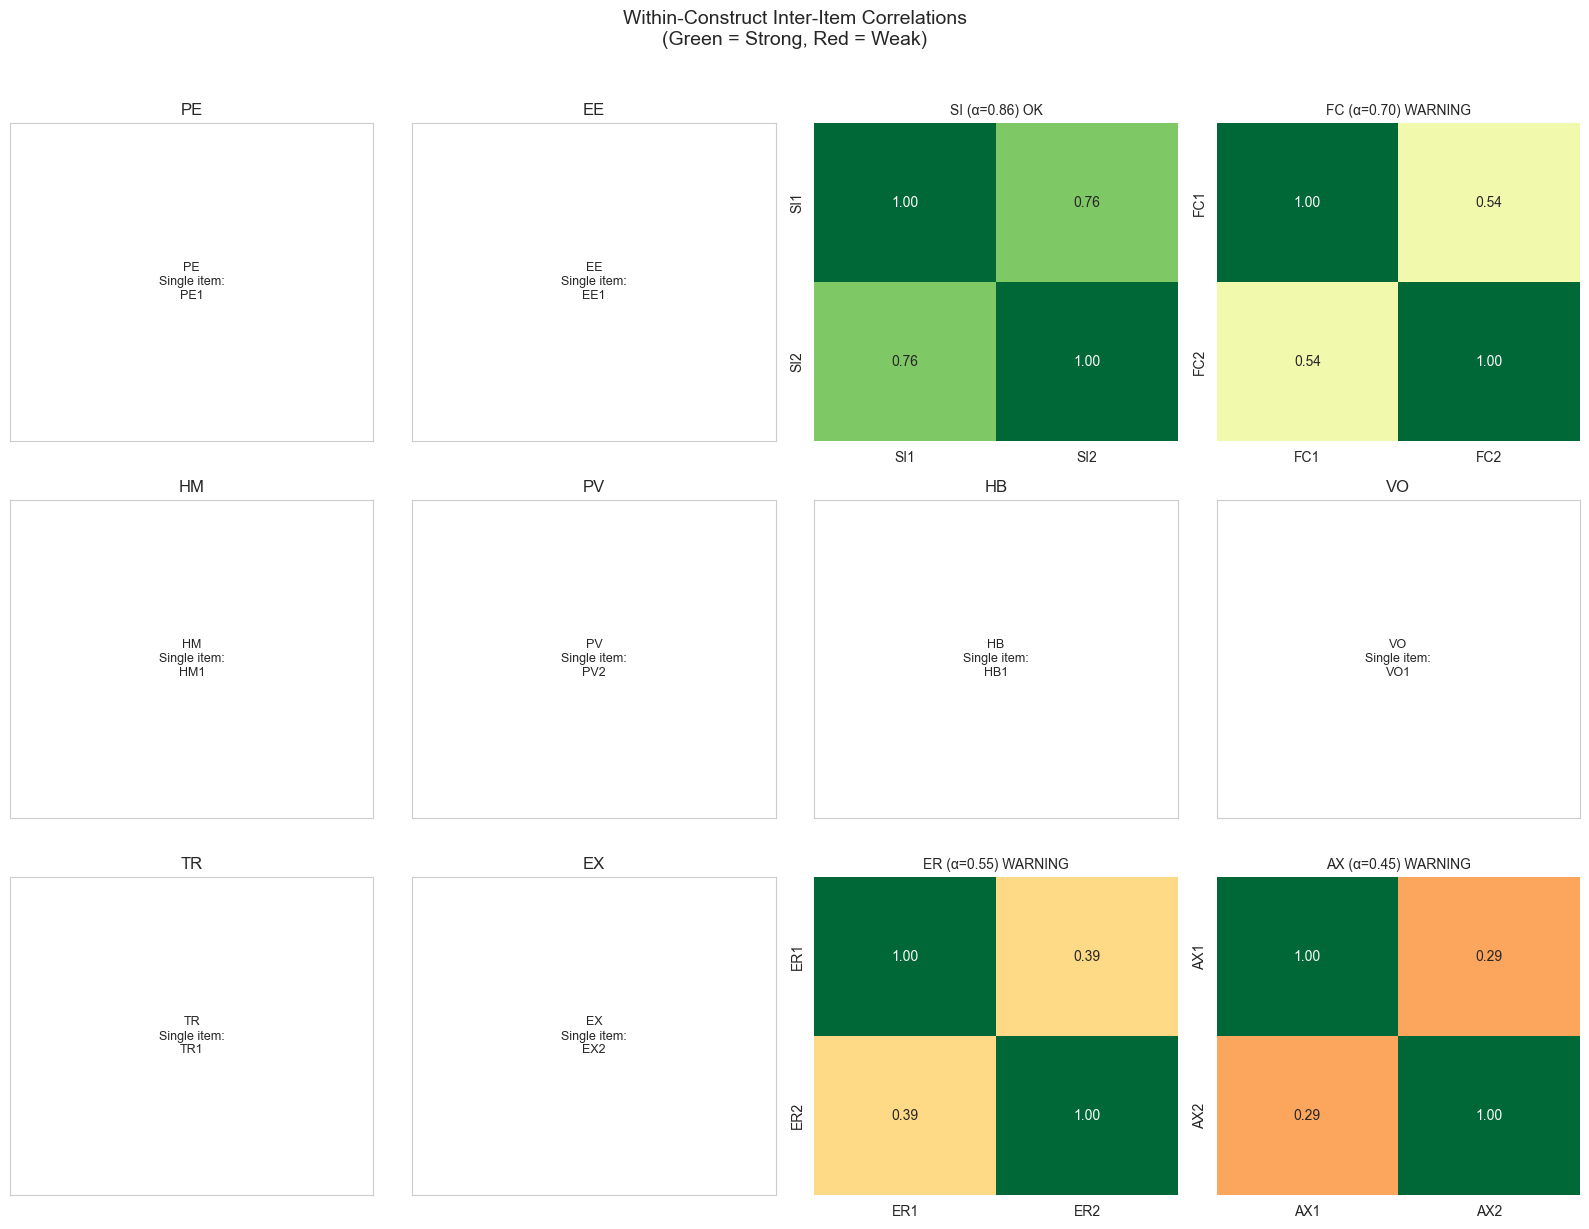


✓ Within-construct correlation heatmaps saved to plots/01_within_construct_correlations.png


In [11]:
# ═══════════════════════════════════════════════════════════════════════════════
# INTER-ITEM CORRELATION HEATMAP BY CONSTRUCT
# ═══════════════════════════════════════════════════════════════════════════════

# Create a comprehensive correlation matrix with construct grouping
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, (construct_name, items) in enumerate(predictor_constructs.items()):
    ax = axes[idx]
    
    # Filter to only items that exist in df_efa
    available_items = [item for item in items if item in df_efa.columns]
    
    if len(available_items) >= 2:
        construct_df = df_efa[available_items]
        corr = construct_df.corr()
        
        # Get alpha for title (handle missing results)
        matching_results = [r for r in construct_results if r['construct'] == construct_name and 'error' not in r]
        if matching_results:
            alpha_val = matching_results[0]['alpha']
            status = ' OK' if alpha_val >= 0.70 else ' WARNING'
            ax.set_title(f"{construct_name} (α={alpha_val:.2f}){status}", fontsize=10)
        else:
            ax.set_title(f"{construct_name}", fontsize=10)
        
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdYlGn', center=0.5,
                   vmin=0, vmax=1, ax=ax, cbar=False,
                   xticklabels=available_items, yticklabels=available_items)
    elif len(available_items) == 1:
        ax.text(0.5, 0.5, f"{construct_name}\nSingle item:\n{available_items[0]}", ha='center', va='center', fontsize=9)
        ax.set_title(construct_name)
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.text(0.5, 0.5, f"{construct_name}\nNo items selected", ha='center', va='center', fontsize=9)
        ax.set_title(construct_name)
        ax.set_xticks([])
        ax.set_yticks([])

# Remove empty subplots if any
for idx in range(len(predictor_constructs), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Within-Construct Inter-Item Correlations\n(Green = Strong, Red = Weak)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('plots/01_within_construct_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Within-construct correlation heatmaps saved to plots/01_within_construct_correlations.png")

In [12]:
# Kaiser-Meyer-Olkin (KMO) Test
kmo_all, kmo_model = calculate_kmo(df_efa)

print(f"KMO Measure of Sampling Adequacy: {kmo_model:.3f}")
print(f"\nInterpretation:")
if kmo_model >= 0.90:
    kmo_interpretation = "Marvelous"
elif kmo_model >= 0.80:
    kmo_interpretation = "Meritorious"
elif kmo_model >= 0.70:
    kmo_interpretation = "Middling"
elif kmo_model >= 0.60:
    kmo_interpretation = "Mediocre"
elif kmo_model >= 0.50:
    kmo_interpretation = "Miserable"
else:
    kmo_interpretation = "Unacceptable"
print(f"  {kmo_interpretation} (Kaiser, 1974)")

# Individual item KMO
print(f"\nItem-level KMO (flagged if < 0.50):")
low_kmo = [(item, kmo) for item, kmo in zip(predictor_items, kmo_all) if kmo < 0.50]
if low_kmo:
    for item, kmo in low_kmo:
        print(f"  ⚠️ {item}: {kmo:.3f}")
else:
    print("  ✓ All items have KMO ≥ 0.50")

KMO Measure of Sampling Adequacy: 0.909

Interpretation:
  Marvelous (Kaiser, 1974)

Item-level KMO (flagged if < 0.50):
  ✓ All items have KMO ≥ 0.50


In [13]:
# Bartlett's Test of Sphericity
chi_square, p_value = calculate_bartlett_sphericity(df_efa)

print(f"Bartlett's Test of Sphericity:")
print(f"  Chi-square: {chi_square:.2f}")
print(f"  p-value: {p_value:.2e}")

if p_value < 0.001:
    print(f"\n✓ Significant (p < .001): Correlation matrix is not an identity matrix")
    print("  Data suitable for factor analysis")
else:
    print(f"\n⚠️ Not significant: Factor analysis may not be appropriate")

Bartlett's Test of Sphericity:
  Chi-square: 1040.77
  p-value: 1.49e-146

✓ Significant (p < .001): Correlation matrix is not an identity matrix
  Data suitable for factor analysis


## 5. Factor Count Determination

In [14]:
# Eigenvalue analysis
fa_eigen = FactorAnalyzer(n_factors=len(predictor_items), rotation=None, method='minres')
fa_eigen.fit(df_efa)

# Get eigenvalues
ev, v = fa_eigen.get_eigenvalues()

# Create eigenvalue table
eigen_df = pd.DataFrame({
    'Factor': range(1, len(ev) + 1),
    'Eigenvalue': ev,
    'Variance %': (ev / sum(ev)) * 100,
    'Cumulative %': np.cumsum((ev / sum(ev)) * 100)
})

print("Eigenvalue Analysis (first 15 factors):")
display(eigen_df.head(15).round(3))

Eigenvalue Analysis (first 15 factors):


,Factor,Eigenvalue,Variance %,Cumulative %
0,1,8.035,50.219,50.219
1,2,2.379,14.870,65.089
2,3,0.925,5.783,70.872
3,4,0.778,4.860,75.732
4,5,0.663,4.144,79.876
5,6,0.521,3.254,83.130
6,7,0.499,3.121,86.251
7,8,0.399,2.494,88.745
8,9,0.357,2.231,90.975
9,10,0.300,1.878,92.853


In [15]:
# Parallel Analysis
def parallel_analysis(data, n_iterations=100, percentile=95):
    """Perform parallel analysis to determine number of factors."""
    n_obs, n_vars = data.shape
    random_eigenvalues = np.zeros((n_iterations, n_vars))
    
    for i in range(n_iterations):
        # Generate random data with same dimensions
        random_data = np.random.normal(size=(n_obs, n_vars))
        random_corr = np.corrcoef(random_data.T)
        random_eigenvalues[i, :] = np.linalg.eigvalsh(random_corr)[::-1]
    
    # Get percentile of random eigenvalues
    random_ev_percentile = np.percentile(random_eigenvalues, percentile, axis=0)
    
    return random_ev_percentile

# Run parallel analysis
np.random.seed(RANDOM_SEED)
random_ev = parallel_analysis(df_efa.values, n_iterations=1000, percentile=95)

# Determine number of factors (where actual > random)
n_factors_pa = sum(ev > random_ev)
n_factors_kaiser = sum(ev > 1)

print(f"Factor Count Recommendations:")
print(f"  Parallel Analysis (95th percentile): {n_factors_pa} factors")
print(f"  Kaiser criterion (eigenvalue > 1): {n_factors_kaiser} factors")
print(f"  Theoretical expectation: 12 factors (8 UTAUT2 + 4 AI-specific)")

Factor Count Recommendations:
  Parallel Analysis (95th percentile): 2 factors
  Kaiser criterion (eigenvalue > 1): 2 factors
  Theoretical expectation: 12 factors (8 UTAUT2 + 4 AI-specific)


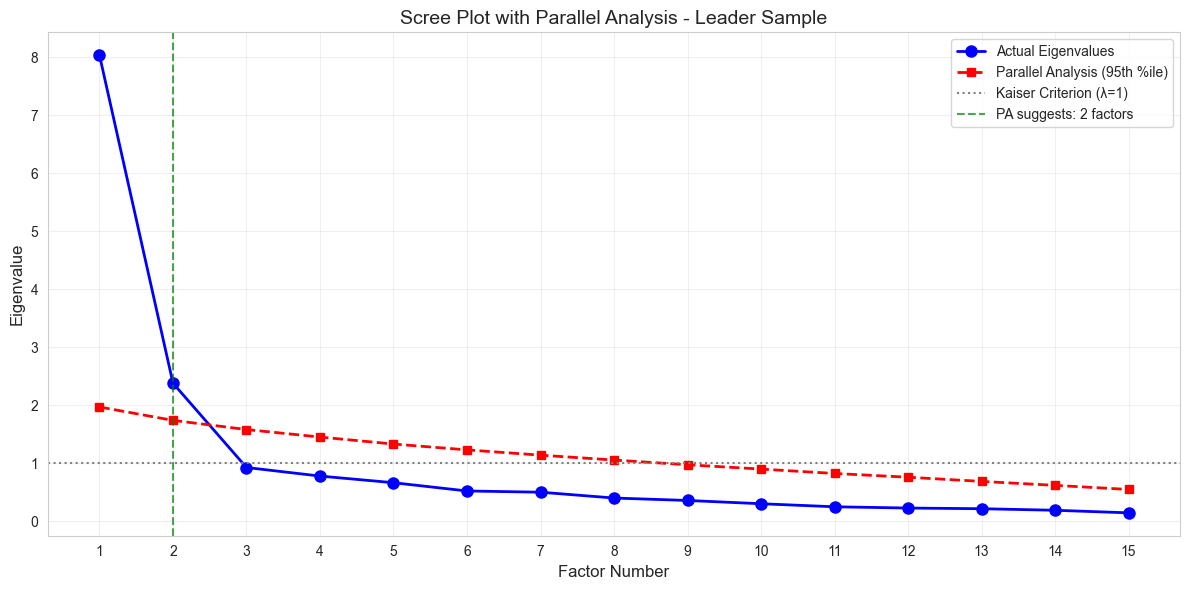


✓ Scree plot saved to plots/01_scree_plot_parallel_analysis.png


In [16]:
# Scree Plot with Parallel Analysis
fig, ax = plt.subplots(figsize=(12, 6))

factors_to_plot = min(15, len(ev))
x = range(1, factors_to_plot + 1)

# Plot actual eigenvalues
ax.plot(x, ev[:factors_to_plot], 'b-o', linewidth=2, markersize=8, label='Actual Eigenvalues')

# Plot parallel analysis threshold
ax.plot(x, random_ev[:factors_to_plot], 'r--s', linewidth=2, markersize=6, label='Parallel Analysis (95th %ile)')

# Kaiser criterion line
ax.axhline(y=1, color='gray', linestyle=':', linewidth=1.5, label='Kaiser Criterion (λ=1)')

# Mark recommended factors
ax.axvline(x=n_factors_pa, color='green', linestyle='--', alpha=0.7, label=f'PA suggests: {n_factors_pa} factors')

ax.set_xlabel('Factor Number', fontsize=12)
ax.set_ylabel('Eigenvalue', fontsize=12)
ax.set_title(f'Scree Plot with Parallel Analysis - {POPULATION.title()} Sample', fontsize=14)
ax.legend(loc='upper right')
ax.set_xticks(x)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/01_scree_plot_parallel_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Scree plot saved to plots/01_scree_plot_parallel_analysis.png")

## 6. Initial EFA - Parallel Analysis Solution

In [17]:
# Use parallel analysis recommended number of factors
n_factors = n_factors_pa

print(f"Fitting EFA with {n_factors} factors (Parallel Analysis recommendation)")
print(f"  Estimator: MINRES (robust to non-normality)")
print(f"  Rotation: Promax (oblique - factors expected to correlate)")

# Fit EFA
efa = FactorAnalyzer(n_factors=n_factors, rotation='promax', method='minres')
efa.fit(df_efa)

# Get loadings
loadings = pd.DataFrame(
    efa.loadings_,
    index=predictor_items,
    columns=[f'F{i+1}' for i in range(n_factors)]
)

print(f"\n✓ EFA fitted successfully")

Fitting EFA with 2 factors (Parallel Analysis recommendation)
  Estimator: MINRES (robust to non-normality)
  Rotation: Promax (oblique - factors expected to correlate)

✓ EFA fitted successfully


In [18]:
# Pattern Matrix (loadings)
def highlight_loadings(val):
    """Highlight significant loadings."""
    if abs(val) >= 0.50:
        return 'background-color: darkgreen; color: white; font-weight: bold'
    elif abs(val) >= 0.32:
        return 'background-color: goldenrod; color: white'
    return ''

# Add construct labels
loadings['Construct'] = [metadata[item]['construct_abbr'] for item in loadings.index]

print(f"Pattern Matrix ({n_factors}-factor solution):")
print("Green = Primary loading (≥0.50), Yellow = Cross-loading (≥0.32)")

# Display styled loadings
factor_cols = [f'F{i+1}' for i in range(n_factors)]
styled = loadings[factor_cols].style.applymap(highlight_loadings).format('{:.3f}')
display(styled)

Pattern Matrix (2-factor solution):
Green = Primary loading (≥0.50), Yellow = Cross-loading (≥0.32)


,F1,F2
PE1,0.747,0.049
EE1,0.651,0.165
SI1,0.830,-0.032
SI2,0.827,0.011
FC1,0.694,0.063
FC2,0.760,-0.075
HM1,0.883,-0.056
PV2,0.855,-0.081
HB1,0.840,-0.037
VO1,0.832,-0.132


In [19]:
# Communalities
communalities = pd.DataFrame({
    'Item': predictor_items,
    'Construct': [metadata[item]['construct_abbr'] for item in predictor_items],
    'Communality': efa.get_communalities()
})

print("Communalities (variance explained by factors):")
print("Flag: < 0.40 indicates item may not fit well")

communalities['Flag'] = communalities['Communality'].apply(
    lambda x: '⚠️ Low' if x < 0.40 else '✓'
)

display(communalities.round(3))

low_comm = communalities[communalities['Communality'] < 0.40]
if len(low_comm) > 0:
    print(f"\n⚠️ {len(low_comm)} item(s) with communality < 0.40")

Communalities (variance explained by factors):
Flag: < 0.40 indicates item may not fit well


,Item,Construct,Communality,Flag
0,PE1,PE,0.560,✓
1,EE1,EE,0.451,✓
2,SI1,SI,0.690,✓
3,SI2,SI,0.684,✓
4,FC1,FC,0.485,✓
5,FC2,FC,0.583,✓
6,HM1,HM,0.782,✓
7,PV2,PV,0.738,✓
8,HB1,HB,0.706,✓
9,VO1,VO,0.709,✓



⚠️ 1 item(s) with communality < 0.40


In [20]:
# Factor Correlations (for oblique rotation)
if hasattr(efa, 'phi_'):
    factor_corr = pd.DataFrame(
        efa.phi_,
        index=[f'F{i+1}' for i in range(n_factors)],
        columns=[f'F{i+1}' for i in range(n_factors)]
    )
    print("Factor Correlation Matrix (Phi):")
    display(factor_corr.round(3))
else:
    print("Factor correlations not available (orthogonal rotation)")

Factor Correlation Matrix (Phi):


,F1,F2
F1,1.000,-0.016
F2,-0.016,1.000


In [21]:
# Variance Explained
variance = efa.get_factor_variance()

var_df = pd.DataFrame({
    'Factor': [f'F{i+1}' for i in range(n_factors)],
    'SS Loadings': variance[0],
    'Proportion Var': variance[1],
    'Cumulative Var': variance[2]
})

print("Variance Explained:")
display(var_df.round(3))

total_var = variance[2][-1] * 100
print(f"\nTotal variance explained: {total_var:.1f}%")

Variance Explained:


,Factor,SS Loadings,Proportion Var,Cumulative Var
0,F1,7.654,0.478,0.478
1,F2,1.974,0.123,0.602



Total variance explained: 60.2%


In [22]:
# ═══════════════════════════════════════════════════════════════════════════════
# HELPER FUNCTIONS (defined here for use in Alternative Factor Solutions)
# ═══════════════════════════════════════════════════════════════════════════════

def calculate_cronbach_alpha(data):
    """Calculate Cronbach's alpha for a set of items."""
    n_items = data.shape[1]
    if n_items < 2:
        return np.nan
    
    item_vars = data.var(axis=0, ddof=1)
    total_var = data.sum(axis=1).var(ddof=1)
    
    alpha = (n_items / (n_items - 1)) * (1 - item_vars.sum() / total_var)
    return alpha

def assess_item_quality(loadings_df, communalities_series, threshold_primary=0.50, threshold_cross=0.32):
    """
    Assess item quality based on:
    - Primary loading ≥ threshold_primary
    - No cross-loadings ≥ threshold_cross (or difference > 0.20)
    - Communality ≥ 0.40
    """
    results = []
    factor_cols = [col for col in loadings_df.columns if col.startswith('F')]
    
    for item in loadings_df.index:
        row = loadings_df.loc[item, factor_cols].abs()
        sorted_loadings = row.sort_values(ascending=False)
        
        primary_factor = sorted_loadings.index[0]
        primary_loading = sorted_loadings.iloc[0]
        secondary_loading = sorted_loadings.iloc[1] if len(sorted_loadings) > 1 else 0
        
        comm = communalities_series[item] if item in communalities_series.index else communalities_series.iloc[list(loadings_df.index).index(item)]
        
        # Check criteria
        issues = []
        
        if primary_loading < threshold_primary:
            issues.append(f'Low primary ({primary_loading:.2f})')
        
        if secondary_loading >= threshold_cross and (primary_loading - secondary_loading) < 0.20:
            issues.append(f'Cross-loading ({secondary_loading:.2f})')
        
        if comm < 0.40:
            issues.append(f'Low communality ({comm:.2f})')
        
        status = '✓ Good' if len(issues) == 0 else '⚠️ ' + '; '.join(issues)
        
        results.append({
            'Item': item,
            'Construct': metadata[item]['construct_abbr'],
            'Primary_Factor': primary_factor,
            'Primary_Loading': primary_loading,
            'Secondary_Loading': secondary_loading,
            'Communality': comm,
            'Status': status
        })
    
    return pd.DataFrame(results)

print("✓ Helper functions defined: calculate_cronbach_alpha(), assess_item_quality()")

✓ Helper functions defined: calculate_cronbach_alpha(), assess_item_quality()


## 7. Alternative Factor Solutions (Theory-Guided Exploration)

Given the discrepancy between parallel analysis (2 factors) and theoretical expectations (12 factors), we explore intermediate solutions using Kaiser's criterion and theoretical guidance.

In [23]:
# ═══════════════════════════════════════════════════════════════════════════════
# Compare multiple factor solutions: 2, 4, 5, 6 factors
# ═══════════════════════════════════════════════════════════════════════════════

def evaluate_efa_solution(df, n_factors, rotation='promax', method='minres'):
    """Fit EFA and return key metrics for comparison."""
    efa = FactorAnalyzer(n_factors=n_factors, rotation=rotation, method=method)
    efa.fit(df)
    
    # Get metrics
    loadings = pd.DataFrame(efa.loadings_, index=df.columns, columns=[f'F{i+1}' for i in range(n_factors)])
    communalities = efa.get_communalities()
    variance = efa.get_factor_variance()
    
    # Count items with primary loading >= 0.50
    good_loadings = 0
    for item in loadings.index:
        max_loading = loadings.loc[item].abs().max()
        if max_loading >= 0.50:
            good_loadings += 1
    
    # Count items with communality >= 0.40
    good_communalities = sum(communalities >= 0.40)
    
    return {
        'n_factors': n_factors,
        'variance_explained': variance[2][-1] * 100,
        'good_loadings': good_loadings,
        'good_communalities': good_communalities,
        'efa': efa,
        'loadings': loadings
    }

# Test solutions - comprehensive range from PA to theoretical
solutions_to_test = [2, 3, 4, 5, 6]
comparison_results = []

print("Comparing Factor Solutions:")
print("="*70)

for n_f in solutions_to_test:
    result = evaluate_efa_solution(df_efa, n_f)
    comparison_results.append(result)
    print(f"\n{n_f}-Factor Solution:")
    print(f"  Variance explained: {result['variance_explained']:.1f}%")
    print(f"  Items with loading ≥ 0.50: {result['good_loadings']}/24")
    print(f"  Items with communality ≥ 0.40: {result['good_communalities']}/24")

# Create comparison table
comparison_df = pd.DataFrame([{
    'Factors': r['n_factors'],
    'Variance %': f"{r['variance_explained']:.1f}",
    'Good Loadings': f"{r['good_loadings']}/24",
    'Good Communalities': f"{r['good_communalities']}/24"
} for r in comparison_results])

print("\n" + "="*70)
print("Summary Comparison:")
display(comparison_df)

Comparing Factor Solutions:

2-Factor Solution:
  Variance explained: 60.2%
  Items with loading ≥ 0.50: 16/24
  Items with communality ≥ 0.40: 15/24

3-Factor Solution:
  Variance explained: 61.1%
  Items with loading ≥ 0.50: 14/24
  Items with communality ≥ 0.40: 13/24

4-Factor Solution:
  Variance explained: 56.3%
  Items with loading ≥ 0.50: 14/24
  Items with communality ≥ 0.40: 11/24

5-Factor Solution:
  Variance explained: 64.4%
  Items with loading ≥ 0.50: 15/24
  Items with communality ≥ 0.40: 14/24

6-Factor Solution:
  Variance explained: 69.5%
  Items with loading ≥ 0.50: 14/24
  Items with communality ≥ 0.40: 15/24

Summary Comparison:

3-Factor Solution:
  Variance explained: 61.1%
  Items with loading ≥ 0.50: 14/24
  Items with communality ≥ 0.40: 13/24

4-Factor Solution:
  Variance explained: 56.3%
  Items with loading ≥ 0.50: 14/24
  Items with communality ≥ 0.40: 11/24

5-Factor Solution:
  Variance explained: 64.4%
  Items with loading ≥ 0.50: 15/24
  Items with c

,Factors,Variance %,Good Loadings,Good Communalities
0,2,60.2,16/24,15/24
1,3,61.1,14/24,13/24
2,4,56.3,14/24,11/24
3,5,64.4,15/24,14/24
4,6,69.5,14/24,15/24


In [24]:
# ═══════════════════════════════════════════════════════════════════════════════
# Detailed Kaiser Factor Solution (empirically determined)
# ═══════════════════════════════════════════════════════════════════════════════

# Use empirically determined Kaiser criterion (eigenvalues > 1)
n_factors_alt = int(n_factors_kaiser)

print(f"Fitting EFA with {n_factors_alt} factors (Kaiser criterion)")
print(f"  Estimator: MINRES")
print(f"  Rotation: Promax (oblique)")

efa_4f = FactorAnalyzer(n_factors=n_factors_alt, rotation='promax', method='minres')
efa_4f.fit(df_efa)

loadings_4f = pd.DataFrame(
    efa_4f.loadings_,
    index=predictor_items,
    columns=[f'F{i+1}' for i in range(n_factors_alt)]
)

# Add construct labels and display
loadings_4f['Construct'] = [metadata[item]['construct_abbr'] for item in loadings_4f.index]

print(f"\nPattern Matrix ({n_factors_alt}-factor solution):")
print("Green = Primary loading (≥0.50), Yellow = Cross-loading (≥0.32)")

factor_cols_4f = [f'F{i+1}' for i in range(n_factors_alt)]
styled_4f = loadings_4f[factor_cols_4f].style.applymap(highlight_loadings).format('{:.3f}')
display(styled_4f)

Fitting EFA with 2 factors (Kaiser criterion)
  Estimator: MINRES
  Rotation: Promax (oblique)

Pattern Matrix (2-factor solution):
Green = Primary loading (≥0.50), Yellow = Cross-loading (≥0.32)


,F1,F2
PE1,0.747,0.049
EE1,0.651,0.165
SI1,0.830,-0.032
SI2,0.827,0.011
FC1,0.694,0.063
FC2,0.760,-0.075
HM1,0.883,-0.056
PV2,0.855,-0.081
HB1,0.840,-0.037
VO1,0.832,-0.132


In [25]:
# ═══════════════════════════════════════════════════════════════════════════════
# Kaiser Factor Item Quality Assessment
# ═══════════════════════════════════════════════════════════════════════════════

# Communalities for Kaiser factor solution
comm_4f = pd.Series(efa_4f.get_communalities(), index=predictor_items)

# Assess quality
quality_4f = assess_item_quality(loadings_4f, comm_4f)

# Summary
good_items_4f = quality_4f[quality_4f['Status'] == '✓ Good']
problem_items_4f = quality_4f[quality_4f['Status'] != '✓ Good']

print(f"{n_factors_alt}-Factor Item Quality Assessment:")
print(f"  ✓ Good items: {len(good_items_4f)}/24")
print(f"  ⚠️ Problem items: {len(problem_items_4f)}/24")

# Map factors to constructs
factor_mapping_4f = {}
for factor in quality_4f['Primary_Factor'].unique():
    factor_items = quality_4f[quality_4f['Primary_Factor'] == factor]
    construct_counts = factor_items['Construct'].value_counts()
    if len(construct_counts) > 0:
        factor_mapping_4f[factor] = construct_counts.to_dict()

print(f"\n{n_factors_alt}-Factor Construct Alignment:")
for factor in sorted(factor_mapping_4f.keys()):
    constructs_str = ', '.join([f"{k}({v})" for k, v in factor_mapping_4f[factor].items()])
    print(f"  {factor}: {constructs_str}")

# Variance explained
var_4f = efa_4f.get_factor_variance()
print(f"\nTotal variance explained: {var_4f[2][-1]*100:.1f}%")

2-Factor Item Quality Assessment:
  ✓ Good items: 14/24
  ⚠️ Problem items: 2/24

2-Factor Construct Alignment:
  F1: FC(2), SI(2), EE(1), PE(1), HM(1), PV(1), HB(1), VO(1), TR(1), EX(1)
  F2: ER(2), AX(2)

Total variance explained: 60.2%


In [26]:
# ═══════════════════════════════════════════════════════════════════════════════
# Kaiser Factor Reliability Analysis
# ═══════════════════════════════════════════════════════════════════════════════

reliability_4f_results = []

for factor in sorted(quality_4f['Primary_Factor'].unique()):
    factor_items = quality_4f[quality_4f['Primary_Factor'] == factor]['Item'].tolist()
    
    if len(factor_items) >= 2:
        alpha = calculate_cronbach_alpha(df_efa[factor_items])
        constructs_in_factor = quality_4f[quality_4f['Primary_Factor'] == factor]['Construct'].value_counts()
        primary_construct = constructs_in_factor.index[0]
        
        reliability_4f_results.append({
            'Factor': factor,
            'N_Items': len(factor_items),
            'Primary_Constructs': ', '.join(constructs_in_factor.index[:2]),
            'Cronbach_Alpha': alpha,
            'Status': '✓' if alpha >= 0.70 else '⚠️ Low' if alpha >= 0.60 else '❌ Poor'
        })

reliability_4f_df = pd.DataFrame(reliability_4f_results)

print(f"{n_factors_alt}-Factor Reliability (Cronbach's Alpha):")
display(reliability_4f_df.round(3))

# Count good reliability
good_alpha_4f = len(reliability_4f_df[reliability_4f_df['Cronbach_Alpha'] >= 0.70])
print(f"\nFactors with α ≥ 0.70: {good_alpha_4f}/{len(reliability_4f_df)}")

2-Factor Reliability (Cronbach's Alpha):


,Factor,N_Items,Primary_Constructs,Cronbach_Alpha,Status
0,F1,12,"FC, SI",0.948,✓
1,F2,4,"ER, AX",0.756,✓



Factors with α ≥ 0.70: 2/2


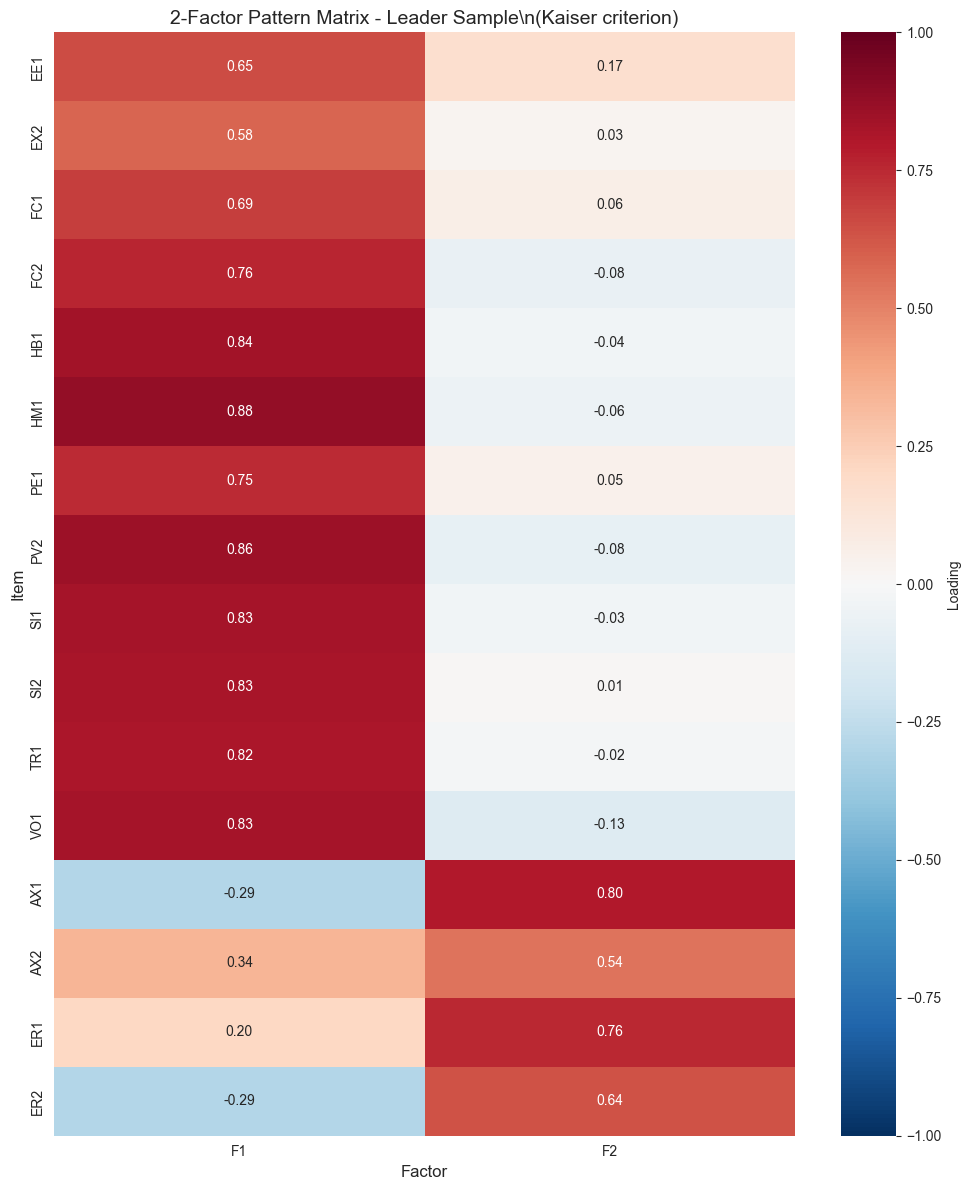

\n✓ 2-factor pattern matrix saved to plots/01_pattern_matrix_2factor.png


In [27]:
# ═══════════════════════════════════════════════════════════════════════════════
# Kaiser Factor Pattern Matrix Heatmap
# ═══════════════════════════════════════════════════════════════════════════════

fig, ax = plt.subplots(figsize=(10, 12))

# Prepare data
heatmap_4f = loadings_4f[factor_cols_4f].copy()
heatmap_4f['Primary'] = heatmap_4f.abs().idxmax(axis=1)
heatmap_4f['Construct'] = [metadata[item]['construct_abbr'] for item in heatmap_4f.index]
heatmap_4f = heatmap_4f.sort_values(['Primary', 'Construct'])
heatmap_4f = heatmap_4f.drop(['Primary', 'Construct'], axis=1)

sns.heatmap(
    heatmap_4f,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    ax=ax,
    cbar_kws={'label': 'Loading'}
)

ax.set_title(f'{n_factors_alt}-Factor Pattern Matrix - {POPULATION.title()} Sample\\n(Kaiser criterion)', fontsize=14)
ax.set_xlabel('Factor', fontsize=12)
ax.set_ylabel('Item', fontsize=12)

plt.tight_layout()
plt.savefig(f'plots/01_pattern_matrix_{n_factors_alt}factor.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\\n✓ {n_factors_alt}-factor pattern matrix saved to plots/01_pattern_matrix_{n_factors_alt}factor.png")

In [28]:
# ═══════════════════════════════════════════════════════════════════════════════
# Solution Comparison Summary
# ═══════════════════════════════════════════════════════════════════════════════

# Calculate 2-factor metrics for comparison (using helper functions defined earlier)
comm_2f = pd.Series(efa.get_communalities(), index=predictor_items)
quality_2f = assess_item_quality(loadings, comm_2f)

good_items_2f = quality_2f[quality_2f['Status'] == '✓ Good']
problem_items_2f = quality_2f[quality_2f['Status'] != '✓ Good']

# Calculate 2-factor reliability
reliability_2f_results = []
for factor in sorted(quality_2f['Primary_Factor'].unique()):
    factor_items = quality_2f[quality_2f['Primary_Factor'] == factor]['Item'].tolist()
    if len(factor_items) >= 2:
        alpha = calculate_cronbach_alpha(df_efa[factor_items])
        reliability_2f_results.append({
            'Factor': factor,
            'Cronbach_Alpha': alpha
        })
reliability_2f_df = pd.DataFrame(reliability_2f_results)
good_alpha_2f = len(reliability_2f_df[reliability_2f_df['Cronbach_Alpha'] >= 0.70])

print("="*70)
print("FACTOR SOLUTION COMPARISON")
print("="*70)

# 2-Factor Summary
print("\n2-FACTOR SOLUTION (Parallel Analysis)")
print("-"*40)
print(f"  Variance explained: {total_var:.1f}%")
print(f"  Good items: {len(good_items_2f)}/24")
print(f"  Problem items: {len(problem_items_2f)}/24")
print(f"  Factors with α ≥ 0.70: {good_alpha_2f}/{len(reliability_2f_df)}")
print("  Factor interpretation:")
print("    F1: General AI Readiness (all positive constructs)")
print("    F2: AI Concerns (ER, AX)")

# Kaiser Factor Summary  
print(f"\n{n_factors_alt}-FACTOR SOLUTION (Kaiser criterion)")
print("-"*40)
print(f"  Variance explained: {var_4f[2][-1]*100:.1f}%")
print(f"  Good items: {len(good_items_4f)}/24")
print(f"  Problem items: {len(problem_items_4f)}/24")
print(f"  Factors with α ≥ 0.70: {good_alpha_4f}/{len(reliability_4f_df)}")
print("  Factor interpretation:")
for factor in sorted(factor_mapping_4f.keys()):
    constructs_str = ', '.join([f"{k}" for k in list(factor_mapping_4f[factor].keys())[:3]])
    print(f"    {factor}: {constructs_str}")

print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)
print(f"""
The 2-factor solution from parallel analysis represents the empirically
optimal structure, but collapses 12 theoretical constructs into just 2 
dimensions. The {n_factors_alt}-factor Kaiser solution provides more 
differentiation among constructs.

For CFA validation, consider:
1. Test 2-factor structure (empirically optimal)
2. Test {n_factors_alt}-factor structure (Kaiser criterion)
3. Test higher-order model with 2 second-order factors
4. Compare results across Academic, Professional, and Full samples
""")

FACTOR SOLUTION COMPARISON

2-FACTOR SOLUTION (Parallel Analysis)
----------------------------------------
  Variance explained: 60.2%
  Good items: 14/24
  Problem items: 2/24
  Factors with α ≥ 0.70: 2/2
  Factor interpretation:
    F1: General AI Readiness (all positive constructs)
    F2: AI Concerns (ER, AX)

2-FACTOR SOLUTION (Kaiser criterion)
----------------------------------------
  Variance explained: 60.2%
  Good items: 14/24
  Problem items: 2/24
  Factors with α ≥ 0.70: 2/2
  Factor interpretation:
    F1: FC, SI, EE
    F2: ER, AX

RECOMMENDATION

The 2-factor solution from parallel analysis represents the empirically
optimal structure, but collapses 12 theoretical constructs into just 2 
dimensions. The 2-factor Kaiser solution provides more 
differentiation among constructs.

For CFA validation, consider:
1. Test 2-factor structure (empirically optimal)
2. Test 2-factor structure (Kaiser criterion)
3. Test higher-order model with 2 second-order factors
4. Compare resul

## 8. Item Quality Assessment

In [29]:
# ═══════════════════════════════════════════════════════════════════════════════
# ITEM QUALITY ASSESSMENT - 2-Factor Solution
# ═══════════════════════════════════════════════════════════════════════════════
# Note: assess_item_quality() function defined earlier in helper functions cell

# Create communalities series
comm_series = pd.Series(efa.get_communalities(), index=predictor_items)

# Assess quality
quality_df = assess_item_quality(loadings, comm_series)

print("Item Quality Assessment:")
display(quality_df.round(3))

# Summary
good_items = quality_df[quality_df['Status'] == '✓ Good']
problem_items = quality_df[quality_df['Status'] != '✓ Good']

print(f"\n✓ Good items: {len(good_items)}/{len(quality_df)}")
print(f"⚠️ Problem items: {len(problem_items)}/{len(quality_df)}")

Item Quality Assessment:


,Item,Construct,Primary_Factor,Primary_Loading,Secondary_Loading,Communality,Status
0,PE1,PE,F1,0.747,0.049,0.560,✓ Good
1,EE1,EE,F1,0.651,0.165,0.451,✓ Good
2,SI1,SI,F1,0.830,0.032,0.690,✓ Good
3,SI2,SI,F1,0.827,0.011,0.684,✓ Good
4,FC1,FC,F1,0.694,0.063,0.485,✓ Good
5,FC2,FC,F1,0.760,0.075,0.583,✓ Good
6,HM1,HM,F1,0.883,0.056,0.782,✓ Good
7,PV2,PV,F1,0.855,0.081,0.738,✓ Good
8,HB1,HB,F1,0.840,0.037,0.706,✓ Good
9,VO1,VO,F1,0.832,0.132,0.709,✓ Good



✓ Good items: 14/16
⚠️ Problem items: 2/16


In [30]:
# Items flagged for potential removal
if len(problem_items) > 0:
    print("Items to consider for removal/review:")
    display(problem_items[['Item', 'Construct', 'Primary_Loading', 'Secondary_Loading', 'Communality', 'Status']])
else:
    print("✓ All items meet quality criteria")

Items to consider for removal/review:


,Item,Construct,Primary_Loading,Secondary_Loading,Communality,Status
11,EX2,EX,0.580841,0.026280,0.338066,⚠️ Low communality (0.34)
15,AX2,AX,0.539371,0.340557,0.406900,⚠️ Cross-loading (0.34)


## 9. Factor-Construct Alignment

In [31]:
# Map factors to theoretical constructs
def map_factors_to_constructs(quality_df, constructs_dict):
    """Map extracted factors to theoretical constructs based on item loadings."""
    factor_mapping = {}
    
    for factor in quality_df['Primary_Factor'].unique():
        factor_items = quality_df[quality_df['Primary_Factor'] == factor]
        construct_counts = factor_items['Construct'].value_counts()
        
        if len(construct_counts) > 0:
            primary_construct = construct_counts.index[0]
            items_from_construct = construct_counts.iloc[0]
            total_items = len(factor_items)
            
            factor_mapping[factor] = {
                'Primary_Construct': primary_construct,
                'Items_From_Construct': items_from_construct,
                'Total_Items': total_items,
                'Purity': items_from_construct / total_items,
                'All_Constructs': construct_counts.to_dict()
            }
    
    return factor_mapping

factor_mapping = map_factors_to_constructs(quality_df, constructs)

print("Factor-Construct Alignment:")
for factor, info in sorted(factor_mapping.items()):
    purity_pct = info['Purity'] * 100
    status = '✓' if purity_pct >= 80 else '⚠️'
    print(f"  {factor} → {info['Primary_Construct']} ({info['Items_From_Construct']}/{info['Total_Items']} items, {purity_pct:.0f}% purity) {status}")
    if info['Purity'] < 1.0:
        other_constructs = {k: v for k, v in info['All_Constructs'].items() if k != info['Primary_Construct']}
        if other_constructs:
            print(f"       Also includes: {other_constructs}")

Factor-Construct Alignment:
  F1 → FC (2/12 items, 17% purity) ⚠️
       Also includes: {'SI': 2, 'EE': 1, 'PE': 1, 'HM': 1, 'PV': 1, 'HB': 1, 'VO': 1, 'TR': 1, 'EX': 1}
  F2 → ER (2/4 items, 50% purity) ⚠️
       Also includes: {'AX': 2}


In [32]:
# Check construct coverage
def check_construct_coverage(quality_df, constructs_dict, min_items=2):
    """Check if each theoretical construct has minimum items with good loadings."""
    coverage = {}
    
    for construct, items in constructs_dict.items():
        if construct == 'BI':  # Skip outcome variable
            continue
            
        # Items from this construct with good primary loadings
        construct_items = quality_df[quality_df['Construct'] == construct]
        good_items = construct_items[construct_items['Primary_Loading'] >= 0.50]
        
        coverage[construct] = {
            'Theoretical_Items': len(items),
            'Items_in_EFA': len(construct_items),
            'Good_Items': len(good_items),
            'Status': '✓' if len(good_items) >= min_items else '⚠️ COVERAGE ISSUE'
        }
    
    return pd.DataFrame(coverage).T

coverage_df = check_construct_coverage(quality_df, constructs)

print("Construct Coverage Check (minimum 2 items per construct):")
display(coverage_df)

coverage_issues = coverage_df[coverage_df['Status'] != '✓']
if len(coverage_issues) > 0:
    print(f"\n⚠️ {len(coverage_issues)} construct(s) with coverage issues")
else:
    print(f"\n✓ All constructs have adequate coverage")

Construct Coverage Check (minimum 2 items per construct):


,Theoretical_Items,Items_in_EFA,Good_Items,Status
PE,2,1,1,⚠️ COVERAGE ISSUE
EE,2,1,1,⚠️ COVERAGE ISSUE
SI,2,2,2,✓
FC,2,2,2,✓
HM,2,1,1,⚠️ COVERAGE ISSUE
PV,2,1,1,⚠️ COVERAGE ISSUE
HB,2,1,1,⚠️ COVERAGE ISSUE
VO,2,1,1,⚠️ COVERAGE ISSUE
TR,2,1,1,⚠️ COVERAGE ISSUE
EX,2,1,1,⚠️ COVERAGE ISSUE



⚠️ 8 construct(s) with coverage issues


## 10. Reliability Analysis

In [33]:
# ═══════════════════════════════════════════════════════════════════════════════
# RELIABILITY ANALYSIS - 2-Factor Solution  
# ═══════════════════════════════════════════════════════════════════════════════
# Note: calculate_cronbach_alpha() function defined earlier in helper functions cell

# Calculate reliability for each factor based on items loading on it
reliability_results = []

for factor in sorted(quality_df['Primary_Factor'].unique()):
    factor_items = quality_df[quality_df['Primary_Factor'] == factor]['Item'].tolist()
    
    if len(factor_items) >= 2:
        alpha = calculate_cronbach_alpha(df_efa[factor_items])
        construct = quality_df[quality_df['Primary_Factor'] == factor]['Construct'].mode().iloc[0]
        
        reliability_results.append({
            'Factor': factor,
            'Primary_Construct': construct,
            'N_Items': len(factor_items),
            'Cronbach_Alpha': alpha,
            'Status': '✓' if alpha >= 0.70 else '⚠️ Low' if alpha >= 0.60 else '❌ Poor'
        })

reliability_df = pd.DataFrame(reliability_results)

print("Factor Reliability (Cronbach's Alpha):")
print("Thresholds: ≥0.70 Good, 0.60-0.69 Acceptable, <0.60 Poor")
display(reliability_df.round(3))

Factor Reliability (Cronbach's Alpha):
Thresholds: ≥0.70 Good, 0.60-0.69 Acceptable, <0.60 Poor


,Factor,Primary_Construct,N_Items,Cronbach_Alpha,Status
0,F1,FC,12,0.948,✓
1,F2,AX,4,0.756,✓


## 11. Factor Structure Visualization

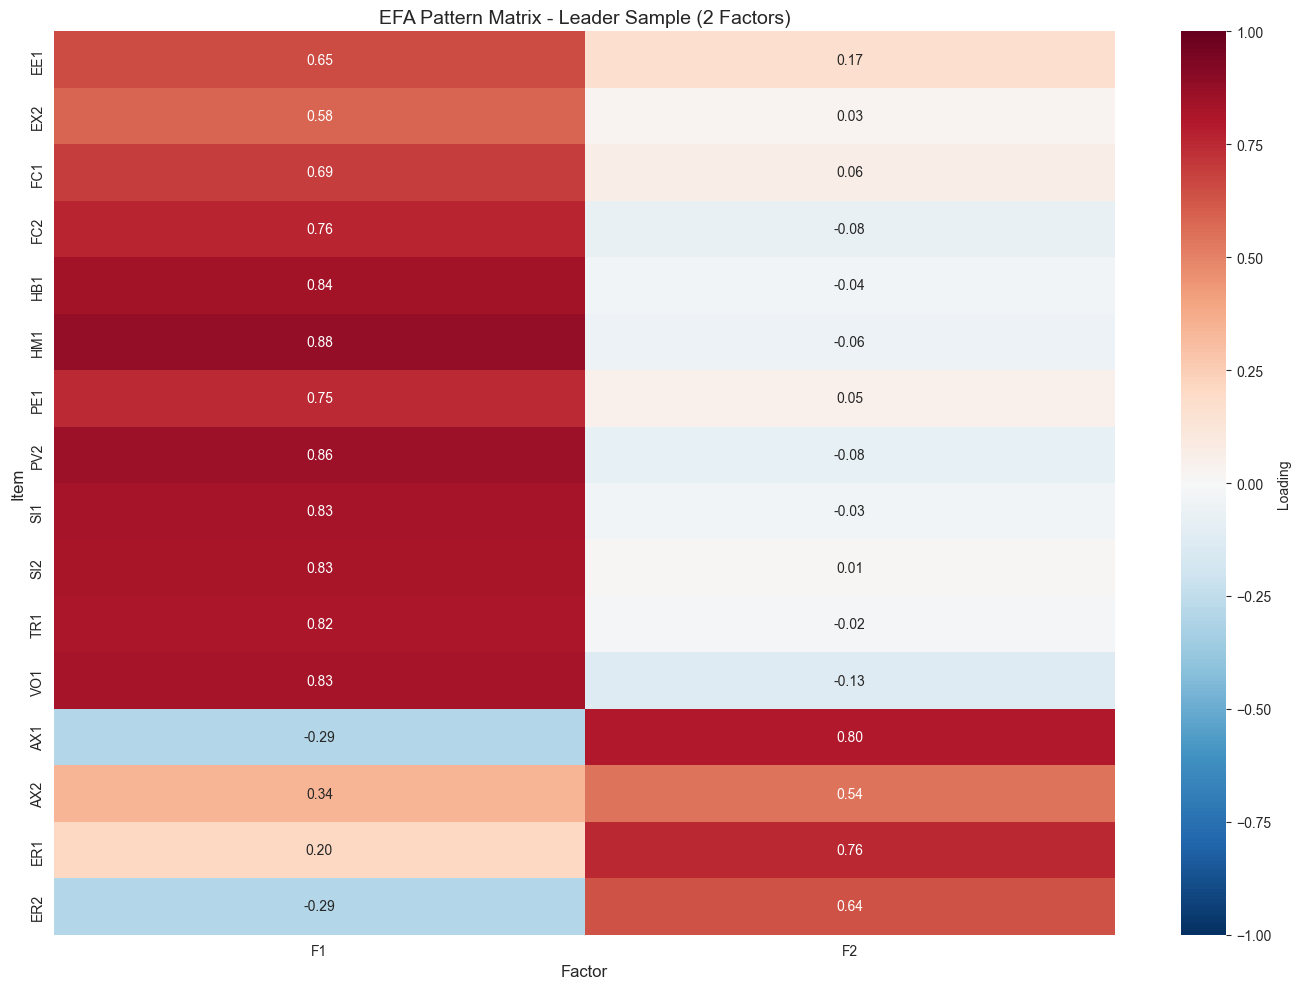


✓ Pattern matrix heatmap saved to plots/01_pattern_matrix_heatmap.png


In [34]:
# Heatmap of factor loadings
fig, ax = plt.subplots(figsize=(14, 10))

# Prepare data for heatmap
factor_cols = [f'F{i+1}' for i in range(n_factors)]
heatmap_data = loadings[factor_cols].copy()

# Sort by primary loading factor
heatmap_data['Primary'] = heatmap_data.abs().idxmax(axis=1)
heatmap_data['Construct'] = [metadata[item]['construct_abbr'] for item in heatmap_data.index]
heatmap_data = heatmap_data.sort_values(['Primary', 'Construct'])
heatmap_data = heatmap_data.drop(['Primary', 'Construct'], axis=1)

# Create heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    ax=ax,
    cbar_kws={'label': 'Loading'}
)

ax.set_title(f'EFA Pattern Matrix - {POPULATION.title()} Sample ({n_factors} Factors)', fontsize=14)
ax.set_xlabel('Factor', fontsize=12)
ax.set_ylabel('Item', fontsize=12)

plt.tight_layout()
plt.savefig('plots/01_pattern_matrix_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Pattern matrix heatmap saved to plots/01_pattern_matrix_heatmap.png")

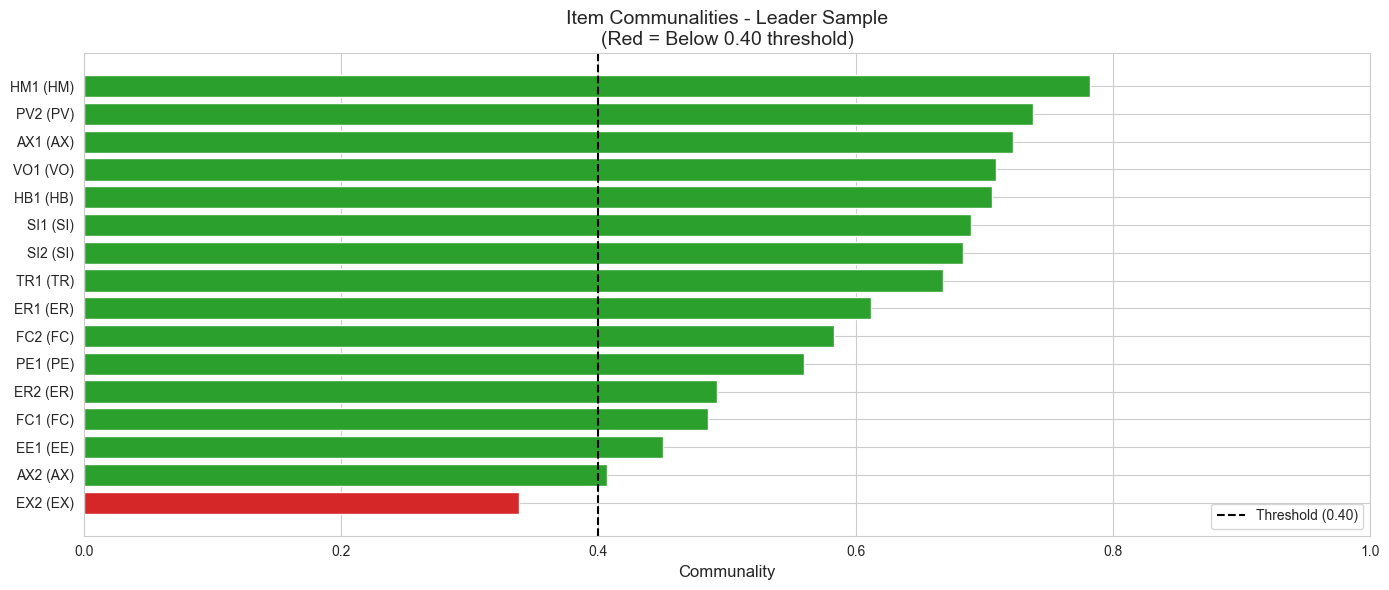


✓ Communality chart saved to plots/01_communality_chart.png
   Items below threshold: 1/16


In [35]:
# Communality Bar Chart - Visualize item quality
fig, ax = plt.subplots(figsize=(14, 6))

# Get communalities and sort
comm_data = pd.DataFrame({
    'Item': loadings.index,
    'Communality': efa.get_communalities(),
    'Construct': [metadata[item]['construct_abbr'] for item in loadings.index]
})
comm_data = comm_data.sort_values('Communality', ascending=True)

# Color by threshold
colors = ['#d62728' if c < 0.4 else '#2ca02c' for c in comm_data['Communality']]

bars = ax.barh(range(len(comm_data)), comm_data['Communality'], color=colors)

# Add threshold line
ax.axvline(x=0.4, color='black', linestyle='--', linewidth=1.5, label='Threshold (0.40)')

# Labels
ax.set_yticks(range(len(comm_data)))
ax.set_yticklabels([f"{row['Item']} ({row['Construct']})" for _, row in comm_data.iterrows()])
ax.set_xlabel('Communality', fontsize=12)
ax.set_title(f'Item Communalities - {POPULATION.title()} Sample\n(Red = Below 0.40 threshold)', fontsize=14)
ax.set_xlim(0, 1)
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('plots/01_communality_chart.png', dpi=150, bbox_inches='tight')
plt.show()

n_low = sum(comm_data['Communality'] < 0.4)
print(f"\n✓ Communality chart saved to plots/01_communality_chart.png")
print(f"   Items below threshold: {n_low}/{len(predictor_items)}")

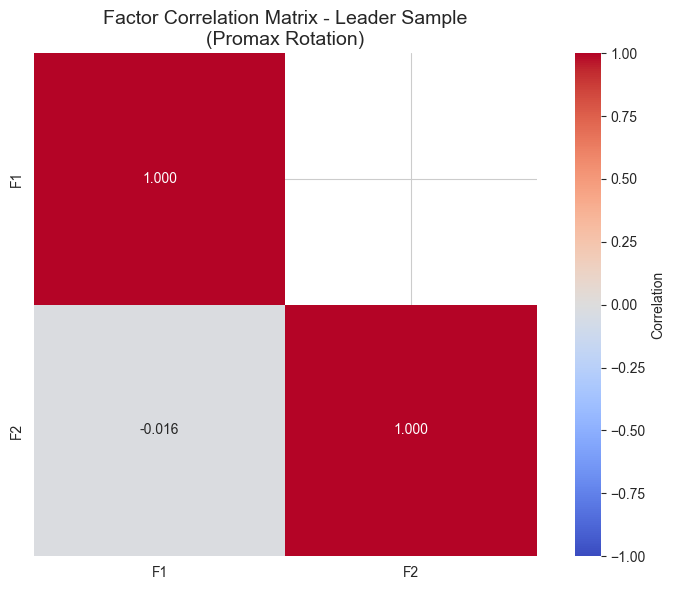


✓ Factor correlation saved to plots/01_factor_correlation.png
   F1-F2 correlation: r = -0.016
   → Consider orthogonal rotation (r ≤ .32)


In [36]:
# Factor Correlation Matrix - Important for oblique rotation justification
fig, ax = plt.subplots(figsize=(8, 6))

# Get factor correlation matrix
factor_corr = pd.DataFrame(
    efa.phi_,  # Factor correlation matrix from Promax rotation
    index=[f'F{i+1}' for i in range(n_factors)],
    columns=[f'F{i+1}' for i in range(n_factors)]
)

# Create heatmap
mask = np.triu(np.ones_like(factor_corr, dtype=bool), k=1)  # Upper triangle mask
sns.heatmap(
    factor_corr,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    ax=ax,
    mask=mask,
    square=True,
    cbar_kws={'label': 'Correlation'}
)

ax.set_title(f'Factor Correlation Matrix - {POPULATION.title()} Sample\n(Promax Rotation)', fontsize=14)

plt.tight_layout()
plt.savefig('plots/01_factor_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

# Report correlation
if n_factors == 2:
    r = factor_corr.iloc[0, 1]
    print(f"\n✓ Factor correlation saved to plots/01_factor_correlation.png")
    print(f"   F1-F2 correlation: r = {r:.3f}")
    if abs(r) > 0.32:
        print("   → Oblique rotation justified (r > .32)")
    else:
        print("   → Consider orthogonal rotation (r ≤ .32)")

## 12. Export Results

In [37]:
# Save pattern matrix
loadings_export = loadings.copy()
loadings_export['Construct'] = [metadata[item]['construct_abbr'] for item in loadings_export.index]
loadings_export['Communality'] = efa.get_communalities()
loadings_export.to_csv('tables/01_pattern_matrix.csv')

# Save item quality assessment
quality_df.to_csv('tables/01_item_quality.csv', index=False)

# Save reliability
reliability_df.to_csv('tables/01_factor_reliability.csv', index=False)

# Save eigenvalues
eigen_df.to_csv('tables/01_eigenvalues.csv', index=False)

print("✓ Results exported to tables/")
print("  - 01_pattern_matrix.csv")
print("  - 01_item_quality.csv")
print("  - 01_factor_reliability.csv")
print("  - 01_eigenvalues.csv")

✓ Results exported to tables/
  - 01_pattern_matrix.csv
  - 01_item_quality.csv
  - 01_factor_reliability.csv
  - 01_eigenvalues.csv


In [38]:
# Export EFA solution as JSON for downstream notebooks
efa_solution = {
    'population': POPULATION,
    'n_dev': int(len(df_dev)),
    'n_factors': int(n_factors),
    'method': 'minres',
    'rotation': 'promax',
    'total_variance_explained': float(variance[2][-1]),
    'kmo': float(kmo_model),
    'bartlett_chi2': float(chi_square),
    'bartlett_p': float(p_value),
    'factor_mapping': {k: v['Primary_Construct'] for k, v in factor_mapping.items()},
    'items_per_factor': {factor: quality_df[quality_df['Primary_Factor'] == factor]['Item'].tolist() 
                         for factor in quality_df['Primary_Factor'].unique()},
    'reliability': {row['Factor']: float(row['Cronbach_Alpha']) for _, row in reliability_df.iterrows()},
    'problem_items': problem_items['Item'].tolist() if len(problem_items) > 0 else []
}

with open('data/efa_solution.json', 'w') as f:
    json.dump(efa_solution, f, indent=2)

print("✓ EFA solution exported to data/efa_solution.json")

✓ EFA solution exported to data/efa_solution.json


In [39]:
# ═══════════════════════════════════════════════════════════════════════════════
# Export ALL EFA solutions for comprehensive CFA testing
# ═══════════════════════════════════════════════════════════════════════════════
# CFA should test all factor solutions explored in EFA, not just the PA-recommended one

import numpy as np

def convert_numpy(obj):
    """Convert numpy types to Python native types for JSON serialization."""
    if isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy(item) for item in obj]
    return obj

def get_items_per_factor(loadings_df):
    """Extract item assignments from loadings matrix."""
    items_per_factor = {}
    factor_cols = [col for col in loadings_df.columns if col.startswith('F')]
    
    for item in loadings_df.index:
        row = loadings_df.loc[item, factor_cols].abs()
        primary_factor = row.idxmax()
        
        if primary_factor not in items_per_factor:
            items_per_factor[primary_factor] = []
        items_per_factor[primary_factor].append(str(item))  # Ensure string
    
    return items_per_factor

def get_loadings_dict(loadings_df):
    """Export loadings as dictionary for CFA model specification."""
    loadings_dict = {}
    factor_cols = [col for col in loadings_df.columns if col.startswith('F')]
    
    for item in loadings_df.index:
        item_loadings = {}
        for factor in factor_cols:
            loading = float(loadings_df.loc[item, factor])
            item_loadings[factor] = loading
        loadings_dict[str(item)] = item_loadings
    
    return loadings_dict

# Build comprehensive solutions export
all_efa_solutions = {
    'population': POPULATION,
    'n_dev': int(len(df_dev)),
    'method': 'minres',
    'rotation': 'promax',
    'kmo': float(kmo_model),
    'bartlett_chi2': float(chi_square),
    'bartlett_p': float(p_value),
    'pa_recommended': int(n_factors_pa),
    'kaiser_recommended': int(n_factors_kaiser),
    'solutions_tested': [int(x) for x in solutions_to_test],
    'solutions': {}
}

for result in comparison_results:
    n_f = int(result['n_factors'])
    loadings_df = result['loadings']
    items_per_factor = get_items_per_factor(loadings_df)
    loadings_export = get_loadings_dict(loadings_df)
    
    # Calculate reliability for each factor in this solution
    reliability = {}
    for factor, items in items_per_factor.items():
        if len(items) >= 2:
            factor_data = df_efa[items]
            n_items = len(items)
            item_vars = factor_data.var(axis=0, ddof=1)
            factor_score_var = factor_data.sum(axis=1).var(ddof=1)  # Renamed to avoid shadowing global total_var
            alpha = (n_items / (n_items - 1)) * (1 - item_vars.sum() / factor_score_var)
            reliability[factor] = float(alpha)
        else:
            reliability[factor] = float('nan')
    
    all_efa_solutions['solutions'][f'{n_f}F'] = {
        'n_factors': n_f,
        'variance_explained': float(result['variance_explained']),
        'good_loadings': int(result['good_loadings']),
        'good_communalities': int(result['good_communalities']),
        'items_per_factor': items_per_factor,
        'loadings': loadings_export,
        'reliability': reliability
    }

# Final conversion to ensure all numpy types are converted
all_efa_solutions = convert_numpy(all_efa_solutions)

# Save all solutions
with open('data/all_efa_solutions.json', 'w') as f:
    json.dump(all_efa_solutions, f, indent=2)

print("✓ ALL EFA solutions exported to data/all_efa_solutions.json")
print(f"   Solutions: {solutions_to_test}")
print(f"   PA recommended: {n_factors_pa}-factor")
print(f"   Kaiser criterion: {n_factors_kaiser}-factor")

✓ ALL EFA solutions exported to data/all_efa_solutions.json
   Solutions: [2, 3, 4, 5, 6]
   PA recommended: 2-factor
   Kaiser criterion: 2-factor


## 13. Summary & Recommendations

In [40]:
# Generate summary
print("="*60)
print(f"EFA SUMMARY - {POPULATION.upper()} SAMPLE")
print("="*60)
print(f"\nSample: N = {len(df_dev)} (development)")
print(f"Items analyzed: {len(predictor_items)}")
print(f"\nFactorability:")
print(f"  KMO: {kmo_model:.3f} ({kmo_interpretation})")
print(f"  Bartlett's χ²: {chi_square:.2f}, p < .001")
print(f"\nFactor Solution:")
print(f"  Factors extracted: {n_factors} (Parallel Analysis)")
print(f"  Variance explained: {total_var:.1f}%")
print(f"  Method: MINRES with Promax rotation")
print(f"\nItem Quality:")
print(f"  Good items: {len(good_items)}/{len(quality_df)}")
print(f"  Problem items: {len(problem_items)}/{len(quality_df)}")
print(f"\nConstruct Coverage:")
print(f"  Constructs with adequate coverage: {len(coverage_df[coverage_df['Status'] == '✓'])}/{len(coverage_df)}")
print(f"\nReliability:")
good_alpha = len(reliability_df[reliability_df['Cronbach_Alpha'] >= 0.70])
print(f"  Factors with α ≥ 0.70: {good_alpha}/{len(reliability_df)}")

EFA SUMMARY - LEADER SAMPLE

Sample: N = 91 (development)
Items analyzed: 16

Factorability:
  KMO: 0.909 (Marvelous)
  Bartlett's χ²: 1040.77, p < .001

Factor Solution:
  Factors extracted: 2 (Parallel Analysis)
  Variance explained: 60.2%
  Method: MINRES with Promax rotation

Item Quality:
  Good items: 14/16
  Problem items: 2/16

Construct Coverage:
  Constructs with adequate coverage: 4/12

Reliability:
  Factors with α ≥ 0.70: 2/2


In [41]:
# Recommendations
print("\nRECOMMENDATIONS:")
print("-"*40)

if len(problem_items) > 0:
    print(f"\n1. Review problematic items:")
    for _, row in problem_items.iterrows():
        print(f"   - {row['Item']} ({row['Construct']}): {row['Status']}")

if len(coverage_issues) > 0:
    print(f"\n2. Address coverage issues:")
    for construct in coverage_issues.index:
        n_good = coverage_issues.loc[construct, 'Good_Items']
        item_word = "item" if n_good == 1 else "items"
        print(f"   - {construct}: Only {n_good} {item_word} with good loadings")

low_reliability = reliability_df[reliability_df['Cronbach_Alpha'] < 0.70]
if len(low_reliability) > 0:
    print(f"\n3. Improve factor reliability:")
    for _, row in low_reliability.iterrows():
        print(f"   - {row['Factor']} ({row['Primary_Construct']}): α = {row['Cronbach_Alpha']:.3f}")

print(f"\n4. Next Steps:")
print(f"   - Run CFA on holdout sample (N=255) to confirm structure")
print(f"   - Compare with Academic and Professional EFA solutions")


RECOMMENDATIONS:
----------------------------------------

1. Review problematic items:
   - EX2 (EX): ⚠️ Low communality (0.34)
   - AX2 (AX): ⚠️ Cross-loading (0.34)

2. Address coverage issues:
   - PE: Only 1 item with good loadings
   - EE: Only 1 item with good loadings
   - HM: Only 1 item with good loadings
   - PV: Only 1 item with good loadings
   - HB: Only 1 item with good loadings
   - VO: Only 1 item with good loadings
   - TR: Only 1 item with good loadings
   - EX: Only 1 item with good loadings

4. Next Steps:
   - Run CFA on holdout sample (N=255) to confirm structure
   - Compare with Academic and Professional EFA solutions


## 14. APA Method Summary

In [42]:
# Dynamic APA-formatted method summary using f-strings
n_dev = len(df_dev)
n_items = len(predictor_items)
n_constructs = len([c for c in constructs.keys() if c != 'BI'])

apa_summary = f"""
### Method Summary (APA Format)

**Exploratory Factor Analysis - {POPULATION.title()} Sample**

An exploratory factor analysis (EFA) was conducted on the {n_items} predictor items using the 
development sample (*N* = {n_dev}). Prior to analysis, the suitability of the data for factor 
analysis was assessed. The Kaiser-Meyer-Olkin measure of sampling adequacy was {kmo_model:.2f}, 
indicating {kmo_interpretation.lower()} factorability (Kaiser, 1974). Bartlett's test of sphericity 
was significant, χ²({n_items * (n_items - 1) // 2}) = {chi_square:.2f}, *p* < .001, indicating that 
correlations between items were sufficiently large for factor analysis.

Factor extraction was performed using the MINRES method, which is robust to violations of normality 
assumptions. The number of factors to retain was determined through parallel analysis (Horn, 1965), 
which suggested a {n_factors}-factor solution. An oblique rotation (Promax) was applied given the 
theoretical expectation that the {n_constructs} constructs (8 UTAUT2 + 4 AI-specific) would be correlated.

The {n_factors}-factor solution explained {total_var:.1f}% of the total variance. Items were retained 
if they demonstrated a primary loading ≥ .50, no cross-loadings ≥ .32 (or a difference of at least 
.20 between primary and secondary loadings), and communality ≥ .40. Of the {n_items} items analyzed, 
{len(good_items)} met all retention criteria and {len(problem_items)} were flagged for review.

Internal consistency reliability was assessed using Cronbach's alpha for each factor. 
{good_alpha} of {len(reliability_df)} factors demonstrated acceptable reliability (α ≥ .70).

The factor solution will be cross-validated using confirmatory factor analysis on the independent 
holdout sample.
"""

display(Markdown(apa_summary))


### Method Summary (APA Format)

**Exploratory Factor Analysis - Leader Sample**

An exploratory factor analysis (EFA) was conducted on the 16 predictor items using the 
development sample (*N* = 91). Prior to analysis, the suitability of the data for factor 
analysis was assessed. The Kaiser-Meyer-Olkin measure of sampling adequacy was 0.91, 
indicating marvelous factorability (Kaiser, 1974). Bartlett's test of sphericity 
was significant, χ²(120) = 1040.77, *p* < .001, indicating that 
correlations between items were sufficiently large for factor analysis.

Factor extraction was performed using the MINRES method, which is robust to violations of normality 
assumptions. The number of factors to retain was determined through parallel analysis (Horn, 1965), 
which suggested a 2-factor solution. An oblique rotation (Promax) was applied given the 
theoretical expectation that the 12 constructs (8 UTAUT2 + 4 AI-specific) would be correlated.

The 2-factor solution explained 60.2% of the total variance. Items were retained 
if they demonstrated a primary loading ≥ .50, no cross-loadings ≥ .32 (or a difference of at least 
.20 between primary and secondary loadings), and communality ≥ .40. Of the 16 items analyzed, 
14 met all retention criteria and 2 were flagged for review.

Internal consistency reliability was assessed using Cronbach's alpha for each factor. 
2 of 2 factors demonstrated acceptable reliability (α ≥ .70).

The factor solution will be cross-validated using confirmatory factor analysis on the independent 
holdout sample.


## 15. EFA Synthesis: Theoretical Expectations vs. Empirical Findings

In [43]:
# =============================================================================
# EFA SYNTHESIS: THEORETICAL EXPECTATIONS VS. EMPIRICAL FINDINGS
# =============================================================================
# This section provides an APA-style synthesis comparing theoretical construct 
# expectations with empirical factor solutions across the tested range.

from IPython.display import display, Markdown

# Theoretical expectations based on AIRS scale design
THEORETICAL_CONSTRUCTS = 12  # 8 UTAUT2 + 4 AI-specific predictor constructs
EXPECTED_FACTORS_FULL = "10-12"  # Full sample expectation per analysis plan
EXPECTED_FACTORS_SUBSAMPLE = "6-10"  # Subsample expectation (smaller N, potential collapse)

# Get population-specific expectation
if POPULATION.lower() == 'full':
    expected_range = EXPECTED_FACTORS_FULL
else:
    expected_range = EXPECTED_FACTORS_SUBSAMPLE

# Build synthesis narrative
synthesis_text = f"""
### Synthesis: Theoretical Framework and Empirical Factor Structure

#### Theoretical Expectations

The AIRS scale was designed to measure {THEORETICAL_CONSTRUCTS} predictor constructs derived from 
two theoretical frameworks: the extended Unified Theory of Acceptance and Use of Technology 
(UTAUT2; Venkatesh et al., 2012) and AI-specific extensions addressing contemporary concerns about 
artificial intelligence adoption (Dwivedi et al., 2021; Shin, 2021).

The eight UTAUT2 constructs include Performance Expectancy (PE), Effort Expectancy (EE), Social 
Influence (SI), Facilitating Conditions (FC), Hedonic Motivation (HM), Price Value (PV), Habit (HT), 
and Behavioral Intention (BI, outcome). The four AI-specific constructs include Trust in AI (TR), 
AI Anxiety (AX), Perceived Ethical Risk (ER), and Explainability Need (XP).

Given the theoretical framework, the **{POPULATION.title()} sample** was expected to yield 
approximately **{expected_range} factors** empirically, accounting for potential construct 
merging due to high inter-construct correlations or splitting due to heterogeneous item content.

#### Empirical Findings

**Factor Retention Criteria.** Two established methods were employed to determine the number of 
factors to retain:

1. **Parallel Analysis (PA)**: Using Horn's (1965) procedure with random eigenvalue comparison, 
   parallel analysis suggested a **{n_factors_pa}-factor solution**. This method is considered 
   the most accurate criterion (Costello & Osborne, 2005; Fabrigar et al., 1999).

2. **Kaiser Criterion**: Retaining factors with eigenvalues > 1.0 suggested a **{n_factors_kaiser}-factor 
   solution**. However, this criterion often over-extracts factors (Costello & Osborne, 2005).

**Factor Comparison Results.** To evaluate solution quality beyond the statistical criteria, 
{len(solutions_to_test)} factor solutions ({', '.join(map(str, sorted(solutions_to_test)))}) were 
systematically compared on variance explained, loading quality, and communalities:

"""

# Add comparison table summary from the comparison_df (using actual column names)
if 'comparison_df' in dir() and comparison_df is not None and len(comparison_df) > 0:
    synthesis_text += """
| Solution | Variance Explained | Good Loadings (≥.50) | Good Communalities (≥.40) |
|----------|-------------------|---------------------|---------------------------|
"""
    for idx, row in comparison_df.iterrows():
        n_f = row['Factors']
        var_exp = row['Variance %']
        good_load = row['Good Loadings']
        good_comm = row['Good Communalities']
        synthesis_text += f"| {n_f}-factor | {var_exp}% | {good_load} | {good_comm} |\n"

synthesis_text += f"""

#### Interpretation: Bridging Theory and Data

The discrepancy between the theoretical expectation of {THEORETICAL_CONSTRUCTS} constructs and the 
parallel analysis suggestion of {n_factors_pa} factors reflects a common phenomenon in psychometric 
research: **empirical dimensional collapse**. Several factors may contribute to this pattern:

1. **High inter-construct correlations**: Theoretically distinct constructs (e.g., Performance 
   Expectancy and Effort Expectancy) may be empirically difficult to separate when respondents 
   perceive them as functionally related.

2. **Sample characteristics**: The {POPULATION.title()} sample (*N* = {n_dev}) may exhibit 
   population-specific response patterns that affect factor differentiation.

3. **Item overlap**: Some items may tap multiple constructs simultaneously, creating cross-loadings 
   that obscure clean factor boundaries.

**Critical distinction**: The {n_factors_pa}-factor PA result represents an **empirical finding**, 
not a theoretical target. EFA serves as a diagnostic tool to examine whether the proposed construct 
structure holds empirically—finding fewer factors suggests construct consolidation, not scale failure.

#### Recommendation for CFA Phase

Based on this EFA exploration, the following approach is recommended for confirmatory factor 
analysis (Phase 2):

1. **Test the full theoretical model** ({THEORETICAL_CONSTRUCTS} factors) to evaluate fit of 
   the a priori structure
2. **Compare alternative models** (including {n_factors_pa}-factor and {n_factors_kaiser}-factor 
   solutions) to assess relative fit
3. **Apply modification indices** judiciously if the theoretical model shows poor fit
4. **Document any respecification** with theoretical justification

The CFA phase will provide definitive evidence regarding whether the theoretical construct 
structure can be confirmed or whether model modifications are warranted.

---
*Analysis conducted using Python factor_analyzer library with MINRES extraction and Promax rotation.*
*Random seed: {RANDOM_SEED} for reproducibility.*
"""

display(Markdown(synthesis_text))


### Synthesis: Theoretical Framework and Empirical Factor Structure

#### Theoretical Expectations

The AIRS scale was designed to measure 12 predictor constructs derived from 
two theoretical frameworks: the extended Unified Theory of Acceptance and Use of Technology 
(UTAUT2; Venkatesh et al., 2012) and AI-specific extensions addressing contemporary concerns about 
artificial intelligence adoption (Dwivedi et al., 2021; Shin, 2021).

The eight UTAUT2 constructs include Performance Expectancy (PE), Effort Expectancy (EE), Social 
Influence (SI), Facilitating Conditions (FC), Hedonic Motivation (HM), Price Value (PV), Habit (HT), 
and Behavioral Intention (BI, outcome). The four AI-specific constructs include Trust in AI (TR), 
AI Anxiety (AX), Perceived Ethical Risk (ER), and Explainability Need (XP).

Given the theoretical framework, the **Leader sample** was expected to yield 
approximately **6-10 factors** empirically, accounting for potential construct 
merging due to high inter-construct correlations or splitting due to heterogeneous item content.

#### Empirical Findings

**Factor Retention Criteria.** Two established methods were employed to determine the number of 
factors to retain:

1. **Parallel Analysis (PA)**: Using Horn's (1965) procedure with random eigenvalue comparison, 
   parallel analysis suggested a **2-factor solution**. This method is considered 
   the most accurate criterion (Costello & Osborne, 2005; Fabrigar et al., 1999).

2. **Kaiser Criterion**: Retaining factors with eigenvalues > 1.0 suggested a **2-factor 
   solution**. However, this criterion often over-extracts factors (Costello & Osborne, 2005).

**Factor Comparison Results.** To evaluate solution quality beyond the statistical criteria, 
5 factor solutions (2, 3, 4, 5, 6) were 
systematically compared on variance explained, loading quality, and communalities:


| Solution | Variance Explained | Good Loadings (≥.50) | Good Communalities (≥.40) |
|----------|-------------------|---------------------|---------------------------|
| 2-factor | 60.2% | 16/24 | 15/24 |
| 3-factor | 61.1% | 14/24 | 13/24 |
| 4-factor | 56.3% | 14/24 | 11/24 |
| 5-factor | 64.4% | 15/24 | 14/24 |
| 6-factor | 69.5% | 14/24 | 15/24 |


#### Interpretation: Bridging Theory and Data

The discrepancy between the theoretical expectation of 12 constructs and the 
parallel analysis suggestion of 2 factors reflects a common phenomenon in psychometric 
research: **empirical dimensional collapse**. Several factors may contribute to this pattern:

1. **High inter-construct correlations**: Theoretically distinct constructs (e.g., Performance 
   Expectancy and Effort Expectancy) may be empirically difficult to separate when respondents 
   perceive them as functionally related.

2. **Sample characteristics**: The Leader sample (*N* = 91) may exhibit 
   population-specific response patterns that affect factor differentiation.

3. **Item overlap**: Some items may tap multiple constructs simultaneously, creating cross-loadings 
   that obscure clean factor boundaries.

**Critical distinction**: The 2-factor PA result represents an **empirical finding**, 
not a theoretical target. EFA serves as a diagnostic tool to examine whether the proposed construct 
structure holds empirically—finding fewer factors suggests construct consolidation, not scale failure.

#### Recommendation for CFA Phase

Based on this EFA exploration, the following approach is recommended for confirmatory factor 
analysis (Phase 2):

1. **Test the full theoretical model** (12 factors) to evaluate fit of 
   the a priori structure
2. **Compare alternative models** (including 2-factor and 2-factor 
   solutions) to assess relative fit
3. **Apply modification indices** judiciously if the theoretical model shows poor fit
4. **Document any respecification** with theoretical justification

The CFA phase will provide definitive evidence regarding whether the theoretical construct 
structure can be confirmed or whether model modifications are warranted.

---
*Analysis conducted using Python factor_analyzer library with MINRES extraction and Promax rotation.*
*Random seed: 67 for reproducibility.*
